In [108]:
from scipy import sparse
import numpy as np
import itertools
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook
from seaborn import kdeplot

import sys
sys.path.append("..")
import utils

from statsmodels.distributions import ECDF

In [300]:
fps = sparse.load_npz('morgan.npz')

In [301]:
def fast_dice(X, Y=None):
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X).astype(bool).astype(int)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y).astype(bool).astype(int)

    intersect = X.dot(Y.T)
    #cardinality = X.sum(1).A
    cardinality_X = X.getnnz(1)[:,None] #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    cardinality_Y = Y.getnnz(1) #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    return (1-(2*intersect) / (cardinality_X+cardinality_Y.T)).A


##The following is to calculate AVE bias:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A

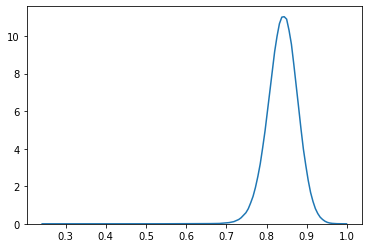

In [302]:
randidx = np.random.choice(337951, 1000, replace=False)
sample = fps[randidx]
similarities = fast_jaccard(sample, sample)
from scipy.spatial.distance import squareform
kdeplot(squareform(similarities))

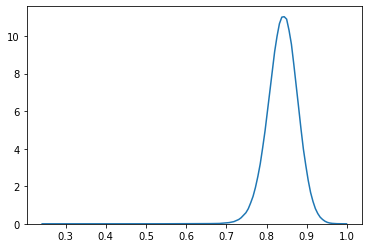

In [303]:
from scipy.spatial.distance import squareform
kdeplot(squareform(similarities))

In [304]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')

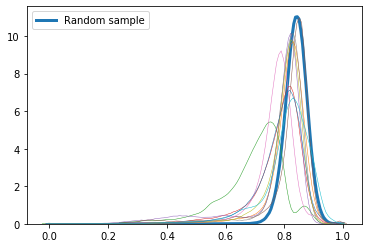

In [306]:
kdeplot(squareform(similarities), label='Random sample', linewidth=3)
for _ in range(10):
    idx = np.random.choice(interaction_matrix.shape[1])
    mask = (interaction_matrix[:,idx].toarray()==1).flatten()
    sample = fps[mask]
    temp_similarities = fast_jaccard(sample, sample)
    j,k = np.triu_indices(temp_similarities.shape[0], k=1)
    kdeplot(temp_similarities[j,k], linewidth=0.5)
    


In [307]:
year=2010

interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')

train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

dates_mask = (interaction_dates.data<=year).astype(int)

#remove entries occuring from `year` and later from train matrix
train.data = train.data * dates_mask
#remove all training data from the test matrix.
test.data = test.data - train.data


row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask]
test = test[row_mask]

#similarly we must now remove any targets that have no data (or not enough) in the training matrix.
column_mask = (np.array(train.sum(0))[0] >= 20)
train = train.T[column_mask].T
test = test.T[column_mask].T


train.eliminate_zeros()
test.eliminate_zeros()

# Run label correlation to validate how ranks are indexed

In [190]:
preds = utils.train_label_correlation(train)

  1%|          | 257/42695 [00:00<00:16, 2564.98it/s]

y_in shape is: (157161, 243)


100%|██████████| 157161/157161 [00:27<00:00, 5650.65it/s]


Evaluate:

In [194]:
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
test_masked = test[row_mask]
get_ranks = test_masked.astype(bool)

In [205]:
m=train[row_mask].astype(bool)

In [209]:
m.toarray()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [210]:
predictions = np.ma.masked_array(preds[row_mask].toarray(), mask=m.toarray())

In [212]:
from scipy.stats.mstats import rankdata
prediction_ranks = rankdata(-predictions, axis=1)

In [214]:
prediction_ranks.shape

(1164, 243)

In [218]:
prediction_ranks[get_ranks.toarray()]

array([ 9., 93., 25., ...,  4.,  2.,  4.])

In [220]:
get_ranks.nonzero()

(array([   0,    0,    0, ..., 1161, 1162, 1163], dtype=int32),
 array([ 13,  39, 175, ..., 161, 138, 161], dtype=int32))

In [222]:
prediction_ranks[0][13]

9.0

In [224]:
prediction_ranks[0][39]

93.0

In [223]:
ranks

array([ 9., 93., 25., ...,  4.,  2.,  4.])

# Compare predicted ranks to structural similarity

In [311]:
fps_short = fps[row_mask]

In [312]:
ligand_idx,target_idx =test.nonzero()
ranks = np.load('label_correlation.npy')

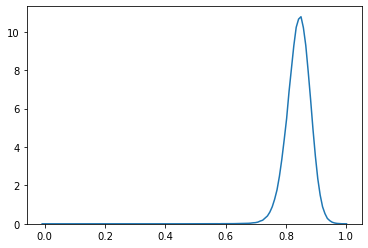

In [314]:
randidx = np.random.choice(fps_short.shape[0], 1000, replace=False)
rsample = fps_short[randidx]
rsimilarities = fast_jaccard(rsample, rsample)
kdeplot(squareform(rsimilarities))

16it [00:00, 72.48it/s]

0 11 8.0
0 36 91.0
0 168 45.0
0 173 27.0
0 216 199.5
63 154 4.0
95 76 2.0
283 154 4.0
460 165 9.0
738 95 11.0
789 45 74.5
911 82 13.0
911 187 30.0
932 17 31.0
983 98 4.0
1066 164 15.0


35it [00:00, 80.54it/s]

1120 60 41.0
1356 26 3.0
1388 165 2.0
1482 165 3.0
1609 7 2.0
1680 120 1.0
1680 158 3.0
1721 66 97.5
1762 158 2.0
1762 170 1.0
1961 68 153.0
2219 81 1.0
2219 115 2.0
2274 202 54.0
2295 132 1.0
2295 134 3.0
2295 155 2.0
2333 217 52.0
2466 98 14.0


55it [00:00, 87.99it/s]

2466 151 2.0
2846 81 2.0
2846 109 1.0
2846 115 3.0
2896 181 1.0
2916 81 1.0
2916 115 2.0
3063 181 1.0
3165 81 1.0
3165 115 2.0
3330 112 1.0
3615 83 1.0
4083 25 2.0
4083 127 1.0
4108 55 1.0
4510 71 2.0
4510 112 1.0
5173 181 1.0
5174 181 1.0
5635 79 122.5
5667 181 1.0


81it [00:00, 103.36it/s]

5746 181 1.0
5932 45 124.5
5967 68 10.0
5985 68 10.0
6041 68 10.0
6088 68 10.0
6193 68 10.0
6193 228 17.0
6346 43 2.0
6346 116 1.0
6402 68 10.0
6402 228 17.0
6703 68 10.0
6703 228 17.0
6827 68 10.0
6827 228 17.0
7275 109 1.0
7328 193 141.5
7592 69 19.5
7592 86 9.0
7850 43 11.0
7934 91 4.0
7952 69 19.5
7952 86 9.0
8105 6 3.0
8105 12 2.0


95it [00:00, 110.55it/s]

8105 29 5.5
8105 154 4.0
8105 159 1.0
8804 86 10.0
8882 213 11.5
8961 38 126.5
9063 13 7.0
9063 16 4.0
9063 17 25.0
9063 35 3.0
9063 48 6.0
9063 84 11.0
9063 86 5.0
9063 87 12.0
9064 83 5.0
9064 98 20.0
9064 165 12.0
9083 65 5.0
9083 73 6.0
9083 77 1.0
9243

118it [00:01, 96.01it/s]

 70 1.0
9243 73 2.0
9377 114 3.0
9439 115 1.0
9512 114 2.0
9518 12 2.0
9518 154 4.0
9518 159 1.0
9695 70 1.0
9788 70 19.0
9788 73 26.0
9788 91 10.0
9788 96 2.0
10080 62 92.0
10080 64 109.0
10080 106 105.5
10286 18 63.0
10457 43 10.0
10457 193 53.5


142it [00:01, 105.26it/s]

10457 217 160.0
10457 228 19.5
10782 47 85.0
10782 120 99.5
10782 158 97.5
10782 170 99.5
11028 83 1.0
11141 68 10.0
11141 228 17.0
11142 68 10.0
11142 228 17.0
11175 68 10.0
11175 228 17.0
11176 68 10.0
11176 228 17.0
11179 68 10.0
11179 228 17.0
11422 149 75.5
11494 83 1.0
11495 83 1.0
11538 68 10.0
11538 228 17.0
11561 6 3.0
11561 12 1.0


167it [00:01, 109.23it/s]

11561 29 5.0
11561 154 4.0
11574 68 10.0
11574 228 17.0
11630 11 6.0
11630 33 10.0
11630 116 4.0
11630 119 33.0
11630 122 50.0
11630 124 3.0
11630 173 22.0
11630 192 13.0
11636 4 1.0
11685 4 1.0
11707 98 1.0
11707 165 22.0
11797 45 124.5
11811 5 80.0
11826 228 132.5
12029 98 2.0
12054 118 21.0
12168 7 9.0
12168 79 5.0


179it [00:01, 100.55it/s]

12256 72 130.0
12256 131 130.0
12263 68 81.0
12277 83 70.5
12297 27 106.5
12714 83 5.0
12731 74 1.0
12812 74 35.0
13102 112 1.0
13132 69 1.0
13132 105 2.0
13348 160 1.0
13361 11 3.0
13615 143 44.5
13615 157 17.0
13615 182 2.0
13618 182 2.0
13645 87 2.0


190it [00:01, 93.61it/s] 

14084 91 4.0
14085 91 4.0
14207 71 115.0
14207 112 122.5
14655 98 6.0
14655 174 49.0
14672 174 49.0
14673 98 6.0
14673 174 49.0
14674 174 49.0
14797 98 119.5
14902 70 1.0
14902 91 2.0
15090 82 14.0


209it [00:02, 85.29it/s]

15090 119 43.5
15090 122 32.0
15143 17 19.5
15145 164 4.0
15211 98 150.0
15211 143 1.0
15233 217 181.0
15250 185 1.0
15250 195 17.0
15285 81 1.0
15285 109 2.0
15315 176 34.0
15519 217 176.0
15527 11 4.0
15527 124 3.0
15540 217 181.0
15563 0 34.0
15563 4 4.0


229it [00:02, 90.61it/s]

15563 9 6.0
15563 14 3.0
15563 26 10.0
15563 28 9.0
15563 33 5.0
15563 66 21.0
15563 67 17.0
15563 116 1.0
15563 129 27.0
15563 133 13.0
15563 135 59.0
15563 142 16.0
15563 161 79.0
15563 168 40.0
15563 169 35.0
15563 171 2.0
15563 176 38.0
15563 189 24.0
15563 190 48.0
15563 192 22.0


249it [00:02, 91.11it/s]

15563 194 15.0
15563 202 67.0
15563 204 20.0
15563 205 49.0
15563 208 37.0
15563 224 53.0
15563 225 23.0
15563 226 44.0
15676 23 7.0
15790 70 2.0
15790 77 4.0
15790 166 29.0
15965 77 1.0
16015 72 3.0
16015 116 2.0
16015 124 5.0
16236 71 1.0
16244 165 4.0


269it [00:02, 88.13it/s]

16475 77 2.0
16516 27 1.0
16660 91 2.0
17257 185 1.0
17565 70 1.0
17580 16 19.0
17580 164 12.5
17621 68 84.0
17683 91 2.0
18803 120 1.0
18803 158 3.0
18803 170 2.0
18822 158 2.0
18822 170 1.0
18860 65 3.0
18860 77 5.0
18969 121 1.0
18971 65 17.0
19000 65 17.0
19003 65 17.0


289it [00:03, 92.04it/s]

19034 121 23.0
19414 98 3.0
19591 0 40.0
19591 9 10.0
19591 11 22.0
19591 14 12.0
19591 26 36.0
19591 28 32.0
19591 32 38.0
19591 33 4.0
19591 37 51.0
19591 43 30.0
19591 72 2.0
19591 82 24.0
19591 116 3.0
19591 118 29.0
19591 122 48.0
19591 124 16.0
19591 126 31.0


310it [00:03, 94.20it/s]

19591 129 21.0
19591 131 1.0
19591 133 15.0
19591 141 27.0
19591 143 9.0
19591 150 41.0
19591 157 6.0
19591 160 55.0
19591 161 59.0
19591 169 35.0
19591 171 5.0
19591 173 25.0
19591 176 26.0
19591 185 69.0
19591 189 49.0
19591 190 46.0
19591 192 20.0
19591 194 19.0
19591 204 11.0
19591 208 28.0
19591 212 23.0


331it [00:03, 95.32it/s]

19591 213 8.0
19591 224 56.0
19591 225 33.0
19847 33 11.0
20064 28 137.0
20064 133 29.0
20065 28 137.0
20065 133 29.0
20066 14 1.0
20109 139 117.5
20172 0 37.0
20172 9 7.0
20172 11 11.0
20172 14 1.0
20172 26 9.0
20172 28 16.0
20172 33 5.0
20172 43 12.0
20172 67 18.0


351it [00:03, 96.25it/s]

20172 72 4.0
20172 82 24.0
20172 116 2.0
20172 122 55.0
20172 129 25.0
20172 133 13.0
20172 141 36.0
20172 142 19.0
20172 168 41.0
20172 169 38.0
20172 173 14.0
20172 189 34.0
20172 190 53.0
20172 213 6.0
20457 28 137.0
20457 133 29.0
20509 27 176.5
20671 64 1.0
20799 48 2.0
21109 51 1.0


371it [00:03, 93.71it/s]

21109 172 136.5
21439 81 122.0
21570 158 27.5
22331 7 8.0
22331 48 20.0
22331 214 1.0
22409 7 72.0
22409 43 10.0
22409 65 160.5
22409 67 7.0
22409 77 66.0
22409 79 74.0
22409 99 160.5
22409 147 9.0
22409 153 160.5
22409 164 101.5
22409 187 26.0
22409 213 1.0
22573 65 3.0


381it [00:04, 86.11it/s]

22791 62 51.0
22791 64 39.0
22791 98 15.0
22851 48 2.0
22868 208 31.0
23172 158 147.5
23172 170 147.5
23220 224 77.0
23243 66 10.0
23259 51 3.0
23259 99 140.0
23494 106 1.0
23825 38 84.0
23825 44 56.5
23825 51 98.0
24310 31 1.0


399it [00:04, 84.07it/s]

24597 65 2.0
24738 31 1.0
24738 79 123.0
25003 101 1.0
25159 77 2.0
25217 25 13.5
25217 34 35.5
25217 127 10.0
25338 77 1.0
25599 65 15.5
25663 34 53.0
25898 77 2.0
25938 83 5.0
26374 77 2.0
26410 34 1.0
26452 77 1.0
26483 67 4.0


417it [00:04, 81.02it/s]

26483 72 1.0
26483 129 16.0
26483 165 47.0
26483 168 24.0
26483 213 2.0
26583 174 124.0
26700 76 2.0
26700 87 1.0
26706 161 7.5
26768 165 11.0
26847 98 19.0
26847 159 1.0
26987 77 1.0
27061 63 1.0
27061 105 2.0
27177 70 4.0


435it [00:04, 81.87it/s]

27287 77 8.5
27533 25 2.0
27533 127 1.0
27835 68 50.0
27835 155 2.0
27835 162 14.0
27835 163 3.0
28072 85 27.5
28072 183 147.5
28171 48 18.0
28171 65 29.0
28171 70 12.0
28171 73 42.0
28171 91 8.5
28768 201 1.0
28842 19 127.0
28869 38 3.0


453it [00:04, 83.42it/s]

28869 51 1.0
29548 34 106.5
30051 154 4.0
30132 101 1.0
30184 33 121.5
30184 47 63.0
30184 158 67.0
30299 148 3.0
30568 33 9.0
30568 47 141.5
30568 68 124.5
30568 118 96.5
30568 121 1.0
30568 149 168.0
30568 155 141.5
30568 158 149.5
30568 163 168.0


472it [00:05, 85.53it/s]

30870 83 17.0
30870 96 23.5
32097 84 14.0
32669 92 1.0
32669 184 2.0
33220 15 189.0
33394 85 89.0
33858 49 152.5
33858 101 152.5
34543 36 28.5
34698 36 28.5
34702 19 127.0
34710 114 139.0
35108 88 1.0
35173 70 2.0
35173 77 4.0
35262 81 1.0
35305 70 1.0


490it [00:05, 83.80it/s]

35305 77 2.0
35305 79 3.0
35306 70 1.0
35306 98 4.0
35307 70 1.0
35307 73 2.0
35310 70 1.0
35314 70 1.0
35314 73 2.0
35355 86 7.0
35355 164 8.0
36031 33 110.0
36031 74 62.0
36031 118 155.0
36031 160 155.0
36031 217 52.0
36139 173 10.0


509it [00:05, 88.08it/s]

36214 152 9.0
36214 185 3.0
36478 38 3.0
36478 44 2.0
36478 51 1.0
36659 38 3.0
36659 51 1.0
36686 98 23.0
36750 72 1.0
36750 121 2.0
36750 142 15.0
36750 143 3.0
36751 66 6.0
36751 72 1.0
36751 121 3.0
36751 142 7.0
36751 143 4.0
36752 72 2.0
36752 121 3.0


527it [00:05, 86.71it/s]

36752 131 1.0
36752 142 5.0
36752 143 4.0
36754 72 1.0
36754 121 2.0
36754 142 12.0
36754 143 3.0
36755 66 7.0
36755 72 1.0
36755 121 2.0
36755 131 9.0
36755 142 20.0
36755 143 3.0
36756 72 1.0
36756 121 2.0
36756 142 16.0
36756 143 3.0
36757 121 2.0


545it [00:06, 85.95it/s]

36757 143 3.0
36761 66 2.0
36761 121 1.0
36761 143 4.0
36762 66 3.0
36762 72 1.0
36762 121 2.0
36762 143 4.0
36763 72 1.0
36763 143 2.0
36764 66 2.0
36764 72 3.0
36764 121 1.0
36764 143 4.0
36765 66 2.0
36765 72 3.0
36765 121 1.0
36765 143 4.0


563it [00:06, 82.65it/s]

36766 66 3.5
36766 121 2.0
36766 143 5.0
36767 43 1.0
36840 158 2.0
36863 149 128.0
36927 157 1.0
36927 202 60.0
36960 175 1.0
37023 71 144.0
37023 112 144.0
37126 131 1.0
37411 105 1.0
37592 62 96.0
37642 114 2.0
37642 115 1.0
37844 98 5.0


581it [00:06, 83.60it/s]

37844 165 4.0
37897 0 14.0
37897 37 25.0
37897 122 24.0
37897 143 5.0
37897 157 1.0
37897 161 39.0
37897 173 8.0
37897 176 11.0
37897 204 4.0
37897 225 13.0
38308 0 118.0
38663 124 3.0
38668 0 118.0
38819 7 10.0
38944 0 118.0
39153 65 2.0


590it [00:06, 84.90it/s]

39303 165 62.5
39465 219 1.0
39466 219 1.0
39621 86 4.0
39793 6 1.0
40079 0 40.0
40079 11 22.0
40079 28 32.0
40079 37 51.0
40079 82 24.0
40079 133 15.0
40079 143 9.0
40079 157 6.0
40079 169 35.0
40079 192 20.0
40079 194 19.0
40079 208 28.0
40079 224 56.0
40122 50 1.0
40661 9 12.0


611it [00:06, 90.09it/s]

40661 11 6.0
40661 33 7.0
40661 67 19.0
40661 82 25.0
40661 94 43.0
40661 116 3.0
40661 118 27.0
40661 122 58.0
40661 124 2.0
40661 126 40.0
40661 169 48.0
40661 173 14.0
40661 189 9.0
40661 208 34.0
40661 212 36.0
40661 225 41.0
41029 68 1.0
41029 182 133.5
41167 228 43.0


631it [00:06, 89.68it/s]

41847 173 6.0
42650 229 163.0
42654 229 163.0
42671 83 4.0
43251 158 1.0
43377 132 1.0
43377 172 2.0
43440 158 1.0
43478 86 8.0
43505 5 3.0
43592 64 25.0
43592 83 7.0
43649 158 1.0
43668 67 13.0
43668 137 56.0
43668 151 61.5
43668 152 61.5
43668 160 57.0
43668 185 60.0


651it [00:07, 90.00it/s]

43800 72 70.5
43800 213 156.5
43911 151 2.0
43911 152 3.0
43911 160 1.0
44172 158 1.0
44189 190 48.0
44289 147 1.0
44289 161 8.0
44301 23 48.0
44301 33 9.0
44301 67 15.0
44301 147 4.0
44301 150 20.0
44323 158 1.0
44401 147 1.0
44401 161 7.5
44461 112 1.0


670it [00:07, 83.35it/s]

44504 207 139.5
44544 158 1.0
44683 158 1.0
44825 85 120.0
44909 125 2.0
44941 109 1.0
45002 98 11.0
45186 165 20.0
45308 49 32.0
45308 101 42.5
45487 137 147.5
45487 185 147.5
45629 181 1.0
45834 149 147.0
46022 51 3.0
46361 9 1.0


688it [00:07, 83.44it/s]

46436 150 18.0
46440 123 5.5
46492 198 147.5
46535 72 2.0
46535 131 1.0
46536 150 21.0
46562 9 2.0
46639 9 6.0
46639 14 4.0
46639 28 13.0
46639 33 3.0
46639 72 2.0
46639 131 1.0
46639 165 44.0
46639 213 5.0
46677 121 2.0
46724 9 3.0
46724 72 2.0


706it [00:07, 81.89it/s]

46724 131 1.0
46724 165 41.0
46861 151 66.5
46861 152 66.5
46861 185 66.5
47075 67 13.0
47075 142 12.0
47209 132 3.0
47209 163 4.0
47263 9 1.0
47285 72 2.0
47285 131 1.0
47309 9 11.0
47309 11 14.0
47309 14 8.0
47309 26 21.0


715it [00:08, 77.29it/s]

47309 28 19.0
47309 32 22.0
47309 33 5.0
47309 72 2.0
47309 98 51.0
47309 116 6.0
47309 131 1.0
47309 157 4.0
47309 171 3.0
47309 194 15.0
47309 213 9.0
47322 131 1.0
47322 147 9.0
47322 171 2.0


732it [00:08, 77.77it/s]

47322 213 5.0
47366 32 7.0
47366 133 3.0
47366 173 4.0
47455 72 2.0
47455 131 1.0
47521 32 25.0
47521 33 1.0
47521 67 9.0
47521 72 2.0
47521 126 12.0
47521 133 6.0
47521 135 47.0
47521 142 8.0
47521 194 5.0
47521 213 3.0
47701 198 155.5


748it [00:08, 77.02it/s]

47717 149 68.5
47804 132 3.0
47804 163 4.0
47944 198 150.0
47967 33 6.0
47967 43 33.0
47967 67 11.0
47967 72 2.0
47967 116 10.0
47967 131 5.0
47967 133 20.0
47967 176 13.0
47967 187 22.0
48186 72 2.0
48186 131 1.0


765it [00:08, 77.32it/s]

48219 143 21.0
48219 157 4.0
48268 131 132.5
48274 33 4.0
48274 142 12.5
48330 145 45.0
48330 182 19.0
48550 148 5.0
48708 64 26.5
48820 9 7.0
48820 14 4.0
48820 28 14.0
48820 33 3.0
48820 72 2.0
48820 131 1.0


782it [00:08, 78.23it/s]

48820 213 6.0
48971 9 11.0
48971 11 12.0
48971 14 7.0
48971 26 17.0
48971 32 25.0
48971 67 16.0
48971 72 4.0
48971 82 5.0
48971 116 8.0
48971 118 33.0
48971 121 13.0
48971 126 10.0
48971 131 1.0
48971 133 24.0
48971 142 14.0
48971 143 26.0


798it [00:09, 76.70it/s]

48971 150 18.0
48971 157 3.0
48971 169 6.0
48971 171 9.0
48971 173 21.0
48971 182 20.0
48971 194 2.0
48971 213 15.0
48971 225 23.0
49005 92 43.5
49005 184 160.0
49133 91 1.0
49188 28 12.0
49188 33 4.5
49188 131 1.0
49188 168 41.0


806it [00:09, 74.00it/s]

49188 187 43.5
49188 194 22.0
49703 43 28.0
50633 131 1.0
50890 185 1.0
51354 134 3.0
51354 155 1.0
51453 81 1.0
51453 109 2.0
51454 81 1.0
51454 109 2.0
52682 83 16.0
52820 120 1.0


822it [00:09, 69.26it/s]

53076 14 9.0
53076 28 28.0
53076 33 6.0
53076 43 29.5
53076 131 2.0
53076 171 5.0
53076 173 14.0
53076 189 34.5
53297 214 1.0
54398 208 18.0
54588 131 1.0
55773 123 5.0
55852 169 27.0
55852 173 7.0
55852 192 10.0
55852 204 6.0
55852 225 19.0


840it [00:09, 73.21it/s]

55920 75 1.0
55920 96 2.0
55924 68 116.5
56363 98 3.0
56729 77 3.0
56809 84 14.0
56854 77 3.0
56938 77 3.0
56958 4 1.0
56997 98 3.0
57358 70 1.0
57643 77 3.0
57794 77 3.0
57799 68 126.5
57942 77 3.0


857it [00:09, 76.60it/s]

57946 68 116.0
58378 77 3.0
58617 77 3.0
58765 0 38.0
58765 11 19.0
58765 157 2.0
58765 192 14.0
58898 114 1.0
58921 68 127.0
58921 149 186.0
58953 114 1.0
59103 122 27.0
59103 143 4.0
59103 171 1.0
59103 204 5.0
59450 158 1.0
59483 183 147.5


873it [00:10, 72.17it/s]

59495 91 1.0
59508 65 2.0
59561 109 1.0
59561 115 2.0
59573 25 2.0
59573 127 1.0
59853 74 57.0
59884 67 12.0
59977 119 1.0
60025 6 1.0
60074 184 159.0
60562 4 144.5
60562 11 3.0
60562 43 5.0


891it [00:10, 79.38it/s]

60562 116 22.0
60562 135 51.0
60562 137 1.0
60562 168 51.0
60562 192 51.0
60562 224 60.5
61199 72 7.0
61613 133 30.0
61736 120 1.0
62791 6 3.0
63691 228 2.5
63980 25 13.5
63980 127 10.0
64413 27 144.0
64413 74 144.0
64525 11 2.0
64679 74 1.0
64721 69 1.0
64721 105 2.0


908it [00:10, 77.00it/s]

64741 96 125.5
64743 74 1.0
64761 22 55.0
64870 7 125.5
64870 65 125.5
64870 77 13.0
64870 79 13.0
64870 91 125.5
64870 106 125.5
64870 164 13.0
64871 74 1.0
64898 127 1.0
65044 81 1.0
65176 7 125.5
65176 79 13.0
65176 84 13.0


924it [00:10, 75.00it/s]

65176 96 125.5
65371 12 2.0
65371 29 5.5
65371 154 4.0
65371 159 1.0
65413 75 23.5
65413 96 23.5
65829 45 152.5
65936 172 4.0
65951 55 1.0
66067 55 1.0
66088 152 4.0
66088 185 1.0
66142 213 5.0
66216 213 7.0
66671

940it [00:11, 72.42it/s]

 54 2.0
66917 48 12.0
66917 65 3.0
66917 70 2.0
66917 91 6.0
66917 164 7.0
67005 81 1.0
67124 112 119.0
67469 98 20.0
67675 143 6.0
67675 176 19.0
67675 204 5.0
67675 225 13.0
68255 28 38.0


956it [00:11, 74.74it/s]

68255 150 34.0
68255 168 37.0
68527 0 37.0
69012 158 124.5
69012 170 155.0
69057 29 5.0
69174 95 1.0
69244 84 6.0
69253 29 5.0
69665 68 70.0
69738 14 3.0
69738 26 13.0
69738 33 4.0
69738 43 11.0
69738 72 1.0
69738 129 21.0


964it [00:11, 73.81it/s]

69738 171 2.0
69738 190 47.0
70002 229 154.0
70454 33 3.0
70454 82 22.0
70454 98 105.0
70454 116 5.0
70454 119 26.0
70454 122 50.0
70454 124 2.0
70454 189 36.0
70454 224 12.0
70478 92 1.0
70510 158 2.0
70510 170 1.0


980it [00:11, 74.97it/s]

70810 28 9.0
70915 104 1.0
71029 28 9.0
71030 28 9.0
71079 174 133.5
71408 12 1.0
71408 29 5.0
71471 88 1.0
71471 93 2.0
71807 33 1.0
71807 192 9.0
71920 71 1.0
71928 165 5.0
71928 215 144.0
72015 114 2.0


996it [00:11, 69.77it/s]

72015 115 1.0
72227 17 19.5
72421 114 2.0
72421 115 1.0
72464 114 3.0
72494 81 2.0
72494 109 1.0
72594 91 1.0
72600 124 1.0
72610 70 1.0
72610 73 2.0
73062 97 1.0
73251 28 9.0
73367 62 2.0


1011it [00:12, 64.87it/s]

73367 106 1.0
73388 104 1.0
73424 158 124.5
73490 13 9.0
73490 84 12.0
73490 87 11.0
73544 149 155.0
73559 92 1.0
73562 88 1.0
73562 93 2.0
73604 79 1.0
73622 91 1.0


1026it [00:12, 66.73it/s]

73835 77 5.0
73835 79 6.0
73836 22 107.5
73865 165 9.0
73886 158 1.0
73953 65 5.0
73953 98 10.0
73953 106 1.0
74251 120 1.0
74252 47 5.5
74252 120 31.0
74252 158 12.5
74252 170 12.5
74286 219 1.0
74357 124 1.0


1034it [00:12, 65.84it/s]

74373 158 1.0
74480 98 38.0
74709 71 1.0
74837 124 1.0
75125 158 1.0
75127 158 1.0
75151 88 1.0
75151 93 2.0
75170 165 17.0
75300 75 2.0


1049it [00:12, 64.58it/s]

75300 83 1.0
75419 0 118.0
75425 34 7.0
75486 14 2.0
75591 45 154.5
75664 91 2.0
75674 47 17.5
75674 120 35.0
75674 149 142.0
75674 158 35.0
75674 170 35.0
75676 0 118.0
75743 36 8.0
75863 47 10.0
75863 120 27.5
75863 158 27.5
75863 170 27.5


1063it [00:12, 66.10it/s]

75960 165 3.0
75964 165 15.0
75989 38 4.0
75989 44 2.0
75989 51 1.0
76013 88 1.0
76013 93 2.0
76041 36 72.0
76072 115 1.0
76191 172 3.0
76338 33 16.0
76338 45 101.0
76338 74 71.0
76338 118 107.5
76338 

1079it [00:13, 70.73it/s]

121 3.0
76347 227 189.0
76392 119 11.5
76801 7 5.0
76801 65 1.0
77135 77 3.0
77441 65 3.0
77583 7 10.0
77583 79 7.5
77830 0 29.0
77830 9 6.0
77830 26 21.0
77830 33 4.0
77830 67 14.0
77830 141 25.0
77830 142 15.0


1097it [00:13, 77.68it/s]

77830 143 16.0
77830 157 8.0
77830 168 31.0
77830 169 30.0
77830 173 12.0
77830 182 35.0
77830 194 13.0
77830 204 18.0
77830 212 28.0
77853 17 22.5
77952 66 140.0
78317 79 1.0
78317 109 39.0
78317 214 151.0
78317 222 151.0
78477 27 1.0
78715 84 1.0


1113it [00:13, 76.43it/s]

78799 84 1.0
78808 71 1.0
79275 85 25.5
79276 174 30.0
79284 22 49.0
79284 23 51.0
79284 122 46.0
79284 148 6.0
79284 161 42.0
79284 192 9.0
79284 224 57.0
79432 217 169.5
79643 84 1.0
79729 84 1.0
79773 84 1.0


1129it [00:13, 74.11it/s]

79805 84 1.0
79816 15 44.0
79816 98 23.0
79953 26 27.0
79953 28 17.0
79953 33 17.0
79953 66 7.0
79953 67 10.0
79953 121 1.0
79953 147 8.5
79953 150 44.5
79953 171 17.0
79953 173 27.0
79953 182 2.0
79953 204 36.0
79953 205 27.0


1145it [00:13, 74.59it/s]

79953 208 44.5
79953 226 17.0
79956 84 1.0
80002 137 55.0
80085 73 1.0
80225 77 1.0
80620 20 1.0
80756 5 3.0
80887 68 80.0
80955 98 5.0
81189 11 3.0
81189 28 8.0
81189 43 10.0
81189 137 43.0
81224 71 1.0


1153it [00:14, 66.11it/s]

81300 68 1.0
81332 47 92.0
81332 120 106.5
81338 25 2.0
81338 127 1.0
81551 5 3.0
81884 96 3.0
82195 45 58.5
82195 74 1.0
82195 158 156.5
82444 27 143.0


1167it [00:14, 63.03it/s]

82487 48 2.0
82746 155 3.0
82746 163 2.0
82991 206 4.0
82998 16 4.0
82998 73 13.0
83176 45 65.5
83192 130 2.0
83571 206 4.0
83588 6 2.0
83588 12 1.0
83588 29 4.0
83588 154 3.0
83835 181 1.0


1182it [00:14, 64.96it/s]

84009 74 99.0
84170 95 1.0
84240 158 2.0
84240 170 1.0
84289 47 6.0
84289 120 7.0
84289 158 133.5
84289 170 9.0
84299 81 1.0
84403 154 4.0
84456 154 3.0
84552 95 1.0
84559 92 1.0
84559 184 2.0


1197it [00:14, 66.74it/s]

84624 154 4.0
84628 47 7.0
84628 120 9.0
84628 158 126.0
84628 170 10.0
84847 154 4.0
85021 0 25.0
85021 14 4.0
85021 94 47.0
85021 176 22.0
85021 194 13.0
85276 48 12.0
85276 70 1.0


1211it [00:14, 65.87it/s]

85555 154 4.0
85800 185 1.0
85802 185 1.0
85803 185 1.0
85804 185 1.0
85862 88 1.0
86180 155 1.0
86180 163 2.0
86286 109 1.0
86286 114 3.0
86483 47 119.5
86483 120 119.5
86483 158 119.5
86483 170 119.5


1227it [00:15, 72.14it/s]

86499 98 5.0
86619 6 3.0
86619 12 2.0
86619 29 5.5
86619 154 4.0
86619 159 1.0
86783 6 3.0
86783 12 2.0
86783 29 5.5
86783 154 4.0
86783 159 1.0
86827 88 1.0
86827 93 2.0
87163 131 2.0
87555 47 5.0
87555 120 7.0


1235it [00:15, 69.63it/s]

87555 158 133.0
87555 170 9.0
87610 132 4.0
87610 134 2.0
87890 77 6.0
87916 114 1.0
88382 93 2.0
88726 129 26.5
88726 131 2.0
88726 171 5.0
88726 190 53.5
89246 149 122.0
89449 13 2.0


1250it [00:15, 65.72it/s]

89702 51 3.0
89798 98 3.0
89847 32 32.0
89847 194 19.5
89912 88 1.0
90138 147 1.0
90313 77 1.0
90387 79 123.0
90569 86 15.0
90740 159 1.0
90840 77 1.0
91101 165 4.0
91128 77 1.0
91128 87 7.0


1265it [00:15, 67.35it/s]

91180 77 3.0
91234 224 61.5
91506 77 5.0
92040 163 1.0
92144 26 8.0
92389 131 3.0
92585 99 147.0
92748 121 29.0
93134 77 2.0
93601 220 1.0
93643 72 1.0
94070 88 1.0
94209 60 46.0
95108 86 8.0
95512 229 163.0


1281it [00:15, 69.75it/s]

95605 7 6.5
95605 153 3.0
95641 147 1.0
95641 161 7.5
95716 158 1.0
95763 65 73.0
95763 76 68.0
95763 84 97.0
95763 87 118.0
95775 229 163.0
95781 67 10.0
95781 135 36.0
95781 142 36.0
95781 168 27.0
96804 165 5.0


1297it [00:16, 68.33it/s]

97215 165 2.0
97440 165 1.0
97880 69 1.0
97880 105 2.0
97923 77 3.0
98069 125 1.0
98791 9 4.0
98791 11 9.0
98791 26 11.0
98791 28 8.0
98791 43 13.0
98791 116 1.0
98791 124 5.0
98791 129 22.0
98791 189 36.0


1314it [00:16, 74.68it/s]

98791 190 48.0
99365 65 3.0
99515 24 2.0
99533 0 35.0
99533 33 3.0
99533 66 7.0
99533 67 15.0
99533 102 14.0
99533 150 31.0
99533 176 19.0
99533 182 40.0
99533 192 13.0
99533 204 5.0
99533 205 37.0
99533 208 21.0
99533 226 26.0
100384 99 145.0


1330it [00:16, 71.24it/s]

100677 217 118.5
101298 11 31.0
101298 43 30.0
101298 143 5.0
101298 150 26.0
101298 157 4.0
101298 161 19.0
101338 15 2.0
101338 51 1.0
101565 77 3.0
101792 158 1.0
101794 0 40.0
101794 9 7.0
101794 14 3.0


1346it [00:16, 71.16it/s]

101794 18 56.0
101794 26 10.0
101794 28 14.0
101794 33 5.0
101794 43 4.0
101794 67 19.0
101794 82 24.0
101794 116 2.0
101794 118 33.0
101794 119 42.0
101794 129 21.0
101794 131 1.0
101794 135 59.0
101794 142 16.0
101794 168 43.0


1364it [00:17, 78.65it/s]

101794 169 39.0
101794 173 13.0
101794 189 49.0
101794 190 54.0
101794 202 65.0
101794 224 58.0
101794 225 25.0
102026 77 3.0
102041 47 1.0
102244 184 156.5
102401 74 62.0
102494 0 4.0
102494 4 5.0
102494 60 10.0
102494 94 16.0
102494 119 6.0
102494 127 106.0
102494 135 7.0


1383it [00:17, 84.76it/s]

102494 143 1.0
102494 160 12.0
102494 161 9.0
102494 185 14.0
102494 204 2.0
102494 224 8.0
102659 165 4.0
102740 38 3.0
103082 111 1.0
103427 15 3.0
103427 44 1.0
103427 51 2.0
103549 67 18.0
103549 135 63.0
103549 142 23.0
103549 168 47.0
103852 70 2.0
104166 74 1.0
104333 67 30.0


1403it [00:17, 87.43it/s]

104333 135 53.5
104333 142 42.0
104333 168 42.0
104383 67 30.0
104383 135 53.5
104383 142 42.0
104383 168 42.0
104660 33 135.0
104660 147 135.0
104660 150 135.0
104671 22 55.0
104715 14 18.5
104715 26 44.5
104715 131 2.0
105197 72 1.0
105262 74 1.0
105263 76 125.5
105263 77 13.0
105263 83 125.5


1412it [00:17, 73.27it/s]

105263 96 125.5
105263 106 125.5
105291 213 7.0
105569 81 1.0
106461 70 3.0
106665 165 9.5
106960 194 13.0
107041 215 3.0
107158 158 127.0
107972 147 1.0
108089 71 1.0
108368 

1429it [00:17, 76.21it/s]

60 58.5
108539 29 5.0
109145 7 2.0
109145 17 35.5
109145 164 10.0
109331 67 22.0
109331 142 15.0
109476 131 2.0
109476 194 16.0
109548 88 1.0
109548 95 2.0
109560 113 16.5
109721 124 1.0
109755 0 37.0
109901 220 1.0
110114 120 1.0
110114 158 3.0


1446it [00:18, 77.50it/s]

110114 170 2.0
110303 68 75.5
110303 121 3.0
110319 71 1.0
110700 131 1.0
110776 114 2.0
110776 115 1.0
110810 71 1.0
110834 225 26.0
110963 148 4.0
110995 124 1.0
111021 214 1.0
111098 114 2.0
111195 92 43.5
111277 17 19.5
111343 77 2.0
111343 79 1.0


1463it [00:18, 73.89it/s]

111389 75 4.0
111389 96 6.0
111389 164 7.0
111402 72 1.0
111439 98 2.0
111535 100 207.0
111535 128 107.0
111535 132 133.5
111535 155 107.0
111555 74 94.0
111577 36 8.0
111577 119 11.5
111592 220 155.0
112138 15 54.0
112138 49 64.0


1471it [00:18, 71.35it/s]

112138 101 61.0
112174 11 2.0
112313 154 4.0
112324 12 1.0
112382 16 6.0
112382 63 3.0
112382 87 1.0
112382 105 4.0
112537 64 1.0
112731 154 4.0
112745 158 126.0
113011 83 5.0
113176 36 28.5
113270 77 1.0


1487it [00:18, 69.39it/s]

113540 77 3.0
114108 171 4.0
114466 0 25.0
114466 11 14.0
114466 67 11.0
114466 82 10.0
114466 142 13.0
114466 143 4.0
114466 157 3.0
114466 168 33.0
114466 176 16.0
114466 204 7.0
114468 112 1.0
114796 47 5.5


1503it [00:18, 70.86it/s]

114796 158 12.5
114796 170 12.5
115116 84 1.0
115122 5 3.0
115208 7 10.0
115208 92 43.5
115208 184 160.0
115214 114 2.0
115214 115 1.0
115228 45 120.0
115681 73 16.0
115681 91 2.0
115847 78 5.0
116008 86 7.0
116349 158 1.0
116441 77 3.0


1519it [00:19, 67.23it/s]

116489 25 2.0
116489 127 1.0
116492 119 34.0
116535 228 2.5
116617 88 1.0
116738 214 1.0
117004 98 3.0
117051 210 1.0
117218 49 54.5
117265 98 6.5
117360 16 5.0
117432 25 2.0
117432 127 1.0


1537it [00:19, 74.83it/s]

117483 154 4.0
117492 45 13.0
117648 68 80.0
117668 17 19.5
117875 164 6.0
117953 66 2.0
118013 32 29.0
118017 22 43.0
118017 60 14.0
118017 121 2.0
118017 150 21.0
118017 161 8.0
118063 34 1.0
118651 49 54.5
118663 9 6.0
118663 26 9.0
118663 28 11.0
118663 33 4.0


1554it [00:19, 75.27it/s]

118663 67 14.0
118663 72 3.0
118663 116 1.0
118663 126 20.0
118663 129 23.0
118663 133 8.0
118663 135 58.0
118663 142 13.0
118663 143 16.0
118663 150 42.0
118663 161 67.0
118663 168 43.0
118663 169 31.0
118663 176 37.0
118663 189 40.0
118663 190 50.0


1571it [00:19, 79.36it/s]

118663 194 12.0
118663 204 15.0
118816 96 125.5
118871 15 48.0
118911 213 10.0
119004 62 2.0
119109 92 1.0
119109 184 2.0
119328 17 38.0
119397 66 148.5
119550 60 31.5
119686 92 3.0
119686 97 41.5
119804 60 31.5
119839 98 70.0
120084 122 21.0
120084 126 12.0


1580it [00:19, 81.74it/s]

120084 194 10.0
120084 213 3.0
120200 32 29.0
120265 55 5.0
120291 92 1.0
120291 184 2.0
120388 32 29.0
120389 32 29.0
120390 32 29.0
120391 11 10.0
120391 32 31.0
120391 67 13.0
120391 72 2.0
120391 124 6.0
120391 189 35.0
120391 213 4.0
120391 225 26.0


1598it [00:20, 79.46it/s]

120432 28 12.0
120494 6 3.0
120494 12 1.0
120494 29 5.0
120494 154 4.0
120719 68 10.0
120719 228 17.0
120902 86 4.0
120968 7 1.0
120968 45 65.0
121057 7 15.0
121057 48 16.0
121057 153 8.0
121057 164 13.0
121080 60 25.0
121113 27 1.0
121115 0 23.0


1616it [00:20, 80.69it/s]

121115 33 5.0
121115 43 22.0
121115 67 14.0
121115 126 26.0
121115 142 15.0
121115 194 10.0
121131 154 4.0
121163 92 1.0
121163 184 2.0
121163 200 7.5
121164 91 13.5
121181 164 10.0
121185 92 1.0
121185 184 2.0
121932 158 2.0


1633it [00:20, 75.75it/s]

121932 170 1.0
122319 213 10.0
122349 26 6.5
122349 28 6.5
122349 116 6.5
122349 224 1.0
122670 71 1.0
122670 88 7.5
122978 16 15.0
123008 17 19.5
123101 123 1.0
123224 154 4.0
123225 154 4.0
123270 154 4.0
123334 154 4.0
123366 213 10.0


1652it [00:20, 81.76it/s]

123387 154 4.0
123486 154 4.0
123516 0 39.0
123516 9 17.0
123516 11 29.0
123516 14 15.0
123516 18 58.0
123516 26 40.0
123516 28 32.0
123516 32 36.0
123516 33 9.0
123516 37 44.0
123516 43 8.0
123516 67 20.0
123516 72 3.0
123516 82 26.0
123516 113 16.0
123516 116 12.0
123516 121 2.0


1670it [00:21, 82.92it/s]

123516 122 45.0
123516 124 22.0
123516 126 37.0
123516 129 28.0
123516 131 5.0
123516 133 24.0
123516 135 54.0
123516 141 30.0
123516 142 21.0
123516 143 7.0
123516 151 76.5
123516 157 4.0
123516 168 33.0
123516 169 43.0
123516 171 11.0
123516 173 31.0


1679it [00:21, 77.11it/s]

123516 176 13.0
123516 189 47.0
123516 190 52.0
123516 192 6.0
123516 194 34.0
123516 202 61.0
123516 212 23.0
123516 213 10.0
123516 224 60.0
123516 225 35.0
123540 17 19.5
123928 97 1.0
123945 73 1.0
123954 73 1.0


1695it [00:21, 68.00it/s]

123962 97 1.0
123962 184 2.0
124037 74 83.0
124037 82 9.0
124037 118 19.0
124037 142 2.0
124037 168 23.0
124037 173 6.0
124037 189 26.0
124072 159 1.0
124087 83 6.0
124196 65 6.0


1711it [00:21, 68.50it/s]

124196 70 1.0
124199 65 2.0
124228 66 77.0
124257 97 1.0
124746 7 125.5
124746 13 13.0
124746 16 125.5
124746 17 13.0
124746 48 125.5
124746 63 2.0
124746 65 125.5
124746 69 13.0
124746 77 13.0
124746 79 13.0
124746 86 13.0
124746 91 125.5
124746 96 125.5
124746 105 13.0
124746 123 13.0
124746 153 13.0


1726it [00:22, 37.56it/s]

125125 81 1.0
125288 29 204.5
125288 154 204.5
125320 54 1.0
125502 88 1.0
125502 95 2.0
125603 15 99.0
125822 65 3.0
125823 65 3.0
125843 222 149.0
126172 91 1.0
126252 81 1.0
126252 109 2.0
126303 54 2.0
126576 51 3.0
126587 17 19.5
126589 17 19.5


1743it [00:22, 51.18it/s]

126599 132 2.0
126599 134 5.0
126599 155 3.0
126599 162 1.0
126599 163 4.0
126599 210 6.0
126608 154 4.0
126644 17 19.5
126668 6 3.0
126668 12 1.0
126668 29 5.0
126668 154 4.0
126760 17 19.5
126766 154 4.0
126781 118 37.0
126833 98 7.0
126834 108 35.0
126852 17 19.5


1761it [00:22, 62.53it/s]

126853 17 19.5
126854 17 19.5
126993 154 4.0
127194 4 37.0
127194 9 9.0
127194 11 18.0
127194 14 3.0
127194 26 38.0
127194 28 17.0
127194 33 6.0
127194 43 13.0
127194 72 5.0
127194 116 1.0
127194 124 2.0


1777it [00:22, 61.07it/s]

127194 129 26.0
127194 171 4.0
127194 173 23.0
127194 189 35.0
127194 190 53.0
127194 194 29.0
127194 202 63.5
127194 225 27.0
127198 154 4.0
127199 154 4.0
127248 154 4.0
127249 154 4.0


1791it [00:23, 62.98it/s]

127481 131 1.0
127554 153 9.0
127558 17 19.5
127909 26 38.0
127909 28 37.0
127909 66 4.0
127909 143 1.0
127909 205 34.0
127909 208 21.0
127909 226 22.0
127910 86 2.0
127910 123 1.0
128175 7 2.0
128175 77 1.0


1805it [00:23, 63.72it/s]

128228 65 17.0
128393 208 17.0
128706 65 3.0
128706 77 2.0
128706 79 4.0
128986 71 125.5
129050 219 1.0
129288 67 1.0
129288 135 43.0
129288 168 14.0
129449 32 42.0
129449 33 9.0
129449 46 187.0


1812it [00:23, 61.70it/s]

129449 72 4.0
129449 121 3.0
129449 124 26.0
129449 126 45.0
129449 131 5.0
129449 132 123.0
129449 134 121.0
129449 155 57.0
129449 163 58.0
129449 165 55.0
129449 173 33.0
129449 194 35.0


1826it [00:23, 59.62it/s]

129449 195 29.0
129449 217 187.0
129450 106 1.0
129645 211 80.0
129713 123 1.0
129729 98 3.0
129729 139 30.0
129729 217 9.0
129848 0 33.0
129848 9 2.0
129848 11 4.0
129848 28 5.0
129848 32 30.0


1840it [00:23, 62.00it/s]

129848 67 10.0
129848 72 1.0
129848 82 26.0
129848 113 17.0
129848 121 11.0
129848 122 43.0
129848 126 22.0
129848 133 8.0
129848 135 44.0
129848 141 20.0
129848 142 13.0
129848 147 18.0


1854it [00:24, 60.82it/s]

129848 161 63.0
129848 168 29.0
129848 169 32.0
129848 173 12.0
129848 176 27.0
129848 182 37.0
129848 189 31.0
129848 194 16.0
129848 202 53.0
129848 204 7.0
129848 208 21.0
129848 212 28.0
129848 225 25.0
130078 7 159.5


1868it [00:24, 60.65it/s]

130078 60 19.0
130078 65 159.5
130078 96 159.5
130078 113 31.0
130078 148 4.0
130614 33 11.0
130614 60 31.5
130626 0 26.0
130626 4 33.0
130626 9 5.0
130626 28 12.0
130626 32 25.0
130626 43 15.0


1882it [00:24, 62.34it/s]

130626 67 2.0
130626 72 3.0
130626 82 16.0
130626 116 1.0
130626 118 24.0
130626 122 38.0
130626 126 19.0
130626 129 17.0
130626 133 9.0
130626 135 36.0
130626 141 22.0
130626 143 11.0
130626 147 10.0
130626 157 6.0


1897it [00:24, 65.17it/s]

130626 161 49.0
130626 169 27.0
130626 176 20.0
130626 182 31.0
130626 187 28.0
130626 190 39.0
130626 192 13.0
130626 202 53.0
130626 204 8.0
130626 208 21.0
130626 212 18.0
130626 213 4.0
130626 225 23.0
130760 7 2.0


1904it [00:25, 64.40it/s]

130760 86 8.0
130827 157 1.0
130828 11 4.0
130828 28 10.0
130868 27 155.0
130868 74 62.0
130868 99 155.0
130918 41 1.0
131102 7 2.0
131413 85 12.0
131413 158 2.0
131413 170 1.0
131450 81 1.0


1918it [00:25, 64.93it/s]

131456 13 14.0
131456 64 1.0
131708 208 30.0
131708 213 3.0
131820 130 1.0
132038 72 4.0
132038 98 153.0
132087 65 2.0
132092 134 1.0
132168 158 3.0
132317 75 65.5
132317 83 70.5
132317 96 70.5


1932it [00:25, 63.03it/s]

132502 97 1.0
132525 32 29.0
132562 60 31.5
132584 68 10.0
132651 6 3.0
132651 154 1.0
132840 7 125.5
132840 17 13.0
132840 35 125.5
132840 63 2.0
132840 65 125.5
132840 69 13.0
132840 77 13.0


1946it [00:25, 62.09it/s]

132840 79 13.0
132840 86 13.0
132840 91 125.5
132840 96 125.5
132840 105 13.0
132840 123 13.0
132944 65 3.0
133103 81 1.0
133149 65 2.0
133402 33 14.0
133402 82 16.0
133402 122 47.0
133402 135 52.0


1961it [00:25, 66.61it/s]

133402 168 43.0
133402 208 35.0
133425 154 4.0
133465 57 1.0
133494 184 160.0
133527 154 4.0
133649 153 9.0
133649 164 14.0
133667 214 1.0
133701 148 3.0
133702 0 15.0
133702 43 11.0
133702 143 5.0
133702 157 2.0
133702 161 38.0
133702 168 12.0


1976it [00:26, 62.75it/s]

133702 176 13.0
133702 204 4.0
133910 154 4.0
133955 7 10.0
133955 17 54.5
133955 79 6.0
133962 118 37.0
134209 11 8.5
134209 18 1.0
134209 122 14.5
134209 135 147.0
134209 202 34.0


1983it [00:26, 59.97it/s]

134520 165 22.0
134561 220 158.0
134598 98 7.0
134689 213 25.0
134735 0 12.0
134735 74 74.0
134735 98 33.0
134735 122 17.0
134735 161 31.0
134735 176 7.0
134735 192 3.0
134735 225 9.0


1997it [00:26, 61.28it/s]

134937 7 15.0
134937 73 10.0
134937 76 12.0
134937 84 11.0
134937 87 9.0
135321 75 3.0
135321 84 1.0
135321 165 11.0
135805 75 7.5
135805 83 12.0
135805 96 4.0
135929 75 8.0
135929 83 7.0


2011it [00:26, 61.61it/s]

135929 96 10.0
136120 28 18.0
136302 165 23.0
136372 68 10.0
136372 228 30.0
136512 68 10.0
136725 154 3.0
136810 68 10.0
136810 228 30.0
136811 68 22.0
136811 228 132.5
136898 68 10.0
136898 228 30.0
137024 68 10.0
137127 0 24.0


2027it [00:26, 63.38it/s]

137127 122 35.0
137127 126 16.0
137127 131 1.0
137127 142 6.0
137127 165 52.0
137127 168 26.0
137281 98 78.0
137281 165 63.0
137457 7 24.0
137457 35 31.5
137457 63 31.5
137457 65 19.0
137457 69 16.0


2041it [00:27, 65.18it/s]

137457 77 19.0
137457 86 4.0
137457 105 24.0
137576 154 3.0
137661 6 4.0
137661 12 2.0
137661 154 3.0
137661 159 1.0
137888 68 10.0
137888 228 30.0
138043 68 10.0
138043 228 30.0
138057 68 10.0
138057 228 30.0


2055it [00:27, 65.10it/s]

138184 118 25.0
138184 168 33.0
138184 173 7.0
138295 45 150.0
138383 68 10.0
138383 228 30.0
138549 68 10.0
138673 71 1.0
138696 119 52.0
138701 50 2.0
138719 12 2.0
138719 54 5.0
138719 154 3.0


2069it [00:27, 66.40it/s]

138719 159 1.0
138740 68 10.0
138740 228 30.0
138925 60 39.0
138940 75 2.0
138940 83 1.0
139247 68 10.0
139247 228 30.0
139297 68 10.0
139297 228 30.0
139405 86 6.0
139412 68 10.0
139412 228 30.0
139504 76 1.0


2083it [00:27, 60.79it/s]

139505 98 3.0
139628 71 1.0
139835 66 1.0
139835 165 43.0
140031 84 1.0
140067 120 1.0
140172 159 1.0
140272 70 6.0
140403 220 1.0
140530 120 1.0
140531 120 1.0


2090it [00:27, 60.88it/s]

140594 109 2.0
140915 118 35.0
140957 120 128.0
140957 158 18.5
140957 170 18.5
141166 98 3.0
141756 143 1.0
141890 120 1.0
141896 98 3.0
141897 98 3.0
141934 98 3.0


2104it [00:28, 59.85it/s]

141938 120 1.0
141971 135 23.0
141971 168 12.0
141971 176 11.0
141971 182 15.0
141971 192 4.0
141971 202 34.0
141971 212 10.0
141972 135 50.0
142011 98 3.0
142033 158 2.0
142033 170 1.0
142052 120 1.0
142087 33 12.0


2118it [00:28, 61.58it/s]

142087 135 59.0
142087 137 2.0
142087 151 22.0
142087 152 29.0
142087 160 8.0
142087 168 39.0
142120 98 3.0
142167 129 22.0
142167 190 53.0
142172 71 1.0
142290 131 1.0
142312 98 3.0


2132it [00:28, 60.38it/s]

142452 0 15.0
142452 37 24.0
142452 72 1.0
142452 129 8.0
142452 135 23.0
142452 143 4.0
142452 157 3.0
142452 161 28.0
142452 204 6.0
142465 158 2.0
142465 170 1.0
142466 158 2.0
142466 170 1.0


2146it [00:28, 63.59it/s]

142467 158 2.0
142467 170 1.0
142474 98 3.0
142475 153 8.0
142480 98 3.0
142520 98 3.0
142521 98 3.0
142570 98 3.0
142599 120 1.0
142600 120 1.0
142613 84 1.0
142633 98 3.0
142634 98 3.0
142636 98 3.0


2160it [00:29, 63.77it/s]

142685 98 3.0
142974 11 10.0
142974 116 3.0
142992 45 25.0
143184 213 7.0
143306 84 1.0
143336 98 3.0
143405 225 74.0
143477 98 3.0
143522 88 1.0
143522 93 2.0
143554 196 142.0
143612 98 3.0


2167it [00:29, 63.64it/s]

143620 88 1.0
143620 95 2.0
143852 98 1.0
143852 123 5.5
143904 98 3.0
143990 6 4.0
144148 29 1.0
144180 137 1.0
144229 73 2.0
144483 45 106.5
144917 84 1.0
144963 165 1.0


2181it [00:29, 62.08it/s]

145216 84 1.0
145389 76 12.0
145716 113 12.0
145717 113 12.0
145774 92 43.5
145774 184 160.0
145971 113 12.0
146046 113 12.0
146166 184 160.0
146175 184 160.0
146497 70 1.0
146497 91 2.0
146526 143 8.0


2195it [00:29, 62.44it/s]

146539 77 1.0
146815 98 30.0
146815 143 8.0
146815 195 1.0
147309 15 96.0
147585 9 7.0
147585 14 8.0
147585 28 15.0
147585 32 25.0
147585 33 6.0
147585 37 52.0
147585 43 20.0
147585 67 12.0
147585 72 4.0
147585 

2210it [00:29, 66.63it/s]

118 30.0
147585 124 2.0
147585 126 14.0
147585 129 26.0
147585 135 56.0
147585 141 28.0
147585 142 11.0
147585 143 19.0
147585 157 9.0
147585 168 38.0
147585 176 37.0
147585 202 60.0
147585 204 22.0
147585 213 5.0


2217it [00:29, 63.05it/s]

147585 225 18.0
147914 92 43.5
147914 184 160.0
147929 72 7.0
147929 126 32.0
147931 0 6.0
147931 11 2.0
147931 121 1.0
147931 151 11.0


2231it [00:30, 56.85it/s]

147931 152 12.0
147931 161 16.0
147931 176 4.0
147931 185 9.0
148000 113 12.0
148218 194 23.0
148223 217 1.0
148256 4 40.0
148378 84 1.0
148795 168 37.0
148826 0 11.0
148826 37 16.0
148826 185 21.0
148826 204 1.0


2246it [00:30, 59.65it/s]

148826 205 13.0
149018 88 1.0
149018 95 2.0
149430 77 2.0
149430 165 26.0
149456 4 59.0
149456 23 67.0
149456 26 33.0
149456 32 44.0
149456 43 11.0
149456 60 65.0
149456 72 6.0
149456 126 39.0


2260it [00:30, 59.97it/s]

149456 131 2.0
149456 158 1.0
149456 173 28.0
149456 189 58.0
149456 195 34.0
149456 213 12.0
149456 217 171.0
149456 224 70.0
149524 74 120.5
149545 75 8.0
149545 83 5.0
149545 96 9.0


2267it [00:30, 58.31it/s]

149545 98 6.0
149545 196 73.0
149641 98 4.0
149864 70 1.0
149864 77 2.0
149864 83 4.0
149864 86 9.0
150098 17 28.0
150179 86 6.0
150179 98 9.0
150294 65 5.0
150331 77 2.0


2279it [00:31, 58.44it/s]

150392 19 153.5
150400 15 126.0
150423 101 47.0
150649 120 1.0
150666 13 3.0
150666 70 4.0
150824 65 4.0
150824 70 1.0
150824 79 6.0
150889 216 116.0
150998 70 1.0
151005 196 138.5
151015 118 29.0
151177 98 16.0


2294it [00:31, 60.62it/s]

151191 84 10.0
151234 114 2.0
151269 114 2.0
151350 16 8.0
151350 17 24.0
151350 63 4.0
151350 84 1.0
151350 87 2.0
151350 105 5.0
151367 84 1.0
151367 87 2.0
151367 98 5.0
151508 18 143.5


2308it [00:31, 61.20it/s]

151508 224 148.0
151542 30 68.0
151542 31 160.5
151589 98 3.0
151648 32 44.0
151854 98 55.0
151859 7 7.0
151859 17 88.0
151859 65 29.0
151859 77 8.5
151859 98 3.0
151859 153 73.0


2321it [00:31, 58.37it/s]

151923 45 28.0
151969 81 68.0
151978 37 52.5
152127 114 2.0
152314 69 1.0
152520 53 2.0
152629 25 2.0
152629 127 1.0
152705 224 61.5
152764 114 3.0
153125 139 11.0


2333it [00:31, 55.39it/s]

153125 165 15.0
153140 164 6.0
153200 48 13.0
153200 65 6.0
153200 70 4.0
153200 73 22.0
153200 77 2.0
153200 91 5.0
153214 98 3.0
153214 139 18.0
153221 158 47.0


2339it [00:32, 53.38it/s]

153402 130 1.0
153494 27 68.0
153494 74 42.0
153542 51 91.0
153542 98 8.0
153542 164 6.0
153565 77 4.0
153604 45 42.5
153647 132 1.0
153700 12 4.0
153700 159 3.0
153783 189 163.5


2352it [00:32, 57.03it/s]

153971 16 7.0
153971 35 6.0
153971 87 1.0
153980 155 3.0
153980 163 2.0
153980 210 5.0
154000 48 22.0
154000 70 17.0
154000 91 22.0
154172 70 1.0
154207 153 10.0
154232 45 141.0


2364it [00:32, 56.36it/s]

154275 92 1.0
154275 184 2.0
154355 45 106.5
154420 92 1.0
154484 36 28.5
154533 81 1.0
154533 109 2.0
154613 36 40.0
154654 27 128.0
154654 74 7.0
154799 70 1.0
154799 73 2.0


2376it [00:32, 54.87it/s]

154841 112 144.0
154901 98 5.0
155264 36 28.5
155306 0 33.0
155306 43 21.0
155306 102 26.0
155306 161 47.0
155306 204 5.0
155596 99 144.0
155596 206 4.0
155644 79 1.0
155680 25 13.5
155680 127 10.0


2389it [00:32, 57.48it/s]

155703 158 59.5
155796 173 18.0
155796 176 17.0
155840 33 2.0
155840 168 38.0
155862 131 2.0
155951 158 2.0
155951 170 1.0
155986 163 2.0
156116 154 4.0
156140 154 4.0
156159 164 9.0
156264 154 4.0


2402it [00:33, 59.66it/s]

156267 154 4.0
156268 154 4.0
156284 154 4.0
156291 154 4.0
156367 88 1.0
156367 95 2.0
156476 70 6.0
156476 91 5.0
156547 154 4.0
156555 120 7.0
156555 158 36.5
156555 170 9.0


2415it [00:33, 58.81it/s]

156611 154 4.0
156612 154 4.0
156672 47 6.0
156672 120 7.0
156672 158 125.0
156672 170 9.0
156704 154 4.0
156727 47 5.0
156727 120 6.0
156727 158 36.5
156727 170 8.0
156805 154 4.0
156904 131 2.0


2422it [00:33, 60.56it/s]


157114 154 4.0


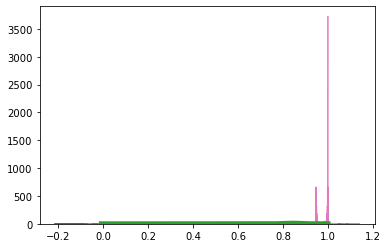

In [315]:
import tqdm
s = list()
for ligand, target, rank in tqdm.tqdm(zip(ligand_idx, target_idx, ranks)):
    print(ligand, target, rank)
    test_fingerprint = fps_short[ligand]
    train_positives_idx,_ = train[:,target].nonzero()
    train_positives = fps_short[train_positives_idx]
    
    
    similarities = fast_dice(test_fingerprint, train_positives)
    s.append(np.mean(similarities))
    kdeplot(similarities[0])
kdeplot(squareform(rsimilarities), linewidth=5)

(0, 50)

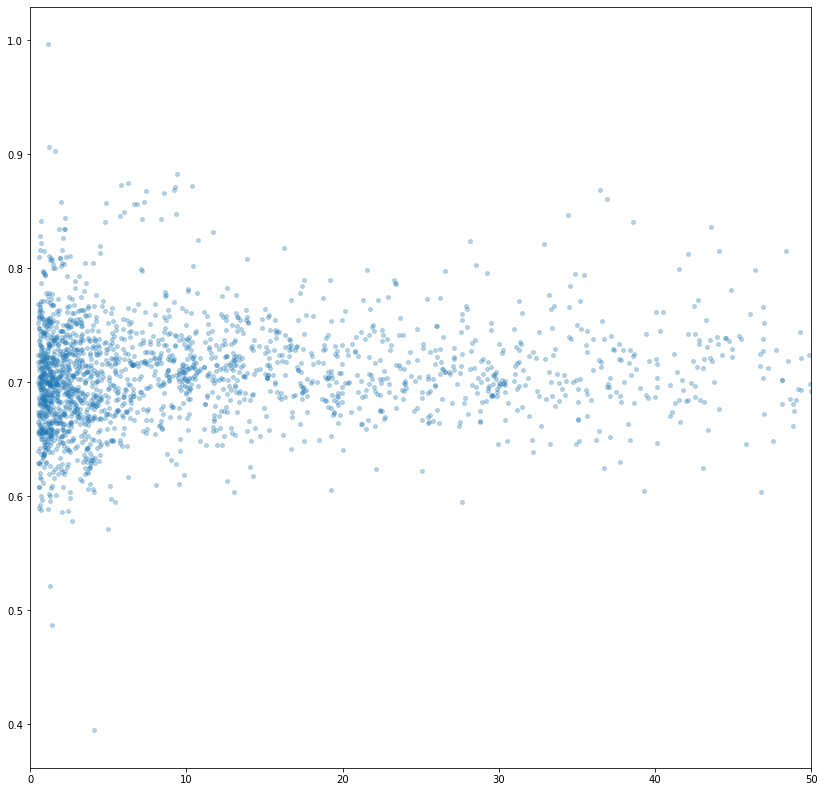

In [336]:
#kdeplot(ranks, s)
plt.figure(figsize=(14,14))
plt.scatter(ranks+np.random.uniform(-0.5, 0.5, len(ranks)), 
            np.array(s)+np.random.uniform(-0.01, 0.01, len(ranks)), s=15, alpha=0.3)
plt.xlim(0,50)

In [337]:
np.argmax(s)

1356

In [265]:
ligand_idx

array([     0,      0,      0, ..., 156805, 156904, 157114], dtype=int32)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


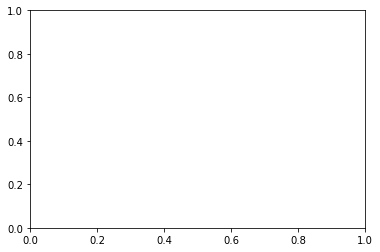

In [266]:
_ix = 221

test_fingerprint = fps_short[ligand_idx[_ix]]
train_positives_idx,_ = train[:,target_idx[_ix]].nonzero()
train_positives = fps_short[train_positives_idx]
    

similarities = fast_dice(test_fingerprint, train_positives)
s.append(np.mean(similarities))
kdeplot(similarities[0])

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

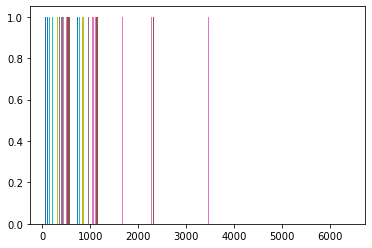

In [273]:
plt.hist(train.sum(0).flatten())

In [278]:
b =np.array(train.sum(0))[0]

In [279]:
b[b.argsort()]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.000e+00, 3.000e+00, 9.000e+00, 9.000e+00, 1.700e+01, 1.900e+01,
       2.200e+01, 4.800e+01, 5.200e+01, 5.400e+01, 5.700e+01, 6.100e+01,
       7.200e+01, 8.100e+01, 8.500e+01, 9.300e+01, 9.700e+01, 9.800e+01,
       1.360e+02, 1.390e+02, 1.400e+02, 1.450e+02, 1.520e+02, 1.620e+02,
       1.620e+02, 1.840e+02, 1.910e+02, 1.930e+02, 1.980e+02, 1.980e+02,
       2.010e+02, 2.050e+02, 2.050e+02, 2.120e+02, 2.170e+02, 2.380e+02,
       2.420e+02, 2.470e+02, 2.640e+02, 2.640e+02, 2.640e+02, 2.720e+02,
       2.740e+02, 2.790e+02, 2.960e+02, 2.980e+02, 3.010e+02, 3.090e+02,
       3.090e+02, 3.110e+02, 3.120e+02, 3.150e+02, 3.160e+02, 3.210e+02,
       3.240e+02, 3.300e+02, 3.370e+02, 3.390e+02, 3.480e+02, 3.510e+02,
       3.640e+02, 3.710e+02, 3.780e+02, 3.800e+02, 3.870e+02, 4.170e+02,
       4.330e+02, 4.430e+02, 4.450e+02, 4.490e+02, 4.530e+02, 4.560e+02,
       4.570e+02, 4.590e+02, 4.660e+02, 4.660e+02, 

In [94]:
import random
prev = 0.;
record = list()
for i in range(0,10000):
        new = 0.99*prev + 2*random.uniform(0,1) - 1
        record.append(new/2. + 0.5)
        prev = new
        
a = np.array(record)

In [95]:
from skimage.measure import block_reduce

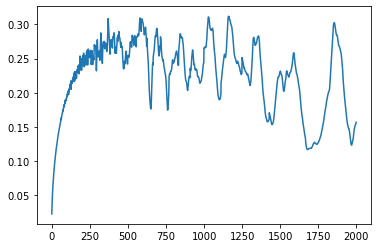

In [107]:
plt.plot([sem(block_reduce(a, (i,), func=np.mean)) for i in range(1,2000)])

In [105]:
from scipy.stats import sem

In [99]:
a.shape

(10000,)

In [88]:
train, test = utils.load_time_split()

In [89]:
allnames = pd.read_csv('../data/subset_targets', header=None)

In [90]:
numligs = np.array(test.sum(0))[0]

In [91]:
numligs.shape

(243,)

In [92]:
allnames['numligs']=numligs

In [96]:
allnames.sort_values('numligs', ascending=False).iloc[:20]

,0,numligs
105,HERG,71.0
161,Histone deacetylase 8,56.0
165,Carbonic anhydrase XII,56.0
84,Serotonin 2a (5-HT2a) receptor,54.0
74,Arachidonate 5-lipoxygenase,47.0
79,Serine/threonine-protein kinase Aurora-B,44.0
36,Tyrosine-protein kinase receptor FLT3,37.0
138,Vascular endothelial growth factor receptor 2,36.0
150,Rho-associated protein kinase 2,36.0
71,Serotonin 1a (5-HT1a) receptor,36.0


In [75]:
allnames

,Leucine-rich repeat serine/threonine-protein kinase 2
0,Bromodomain-containing protein 4
1,Nuclear receptor ROR-gamma
2,Nicotinamide phosphoribosyltransferase
3,Corticotropin releasing factor receptor 1
4,Prostanoid EP1 receptor
...,...
237,Glucose-dependent insulinotropic receptor
238,Prostaglandin E synthase
239,Mitogen-activated protein kinase kinase kinase 14
240,Smoothened homolog


In [4]:
def calc_ecdf(ranks):
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]
    return ecdf

def calc_kde(ranks, xs=np.linspace(0,243,243)):
    #kde:
    density = gaussian_kde(ranks)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

In [5]:
##First we will take the three best performing algorithms and
##take the geometric average of their rankings:
ranks = [np.load(name+'.npy') for name in ['label_correlation', 'hpo_implicit_bpr', 'hpo_lightfm_warp']]
geo_avg = np.power(ranks[0]*ranks[1]*ranks[2], 1/3)

##Now we can proceed to graph all the rankings:
##Filenames for the algos to load parameters:
filenames = ['geometric_avg', 'label_correlation', 'hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr']

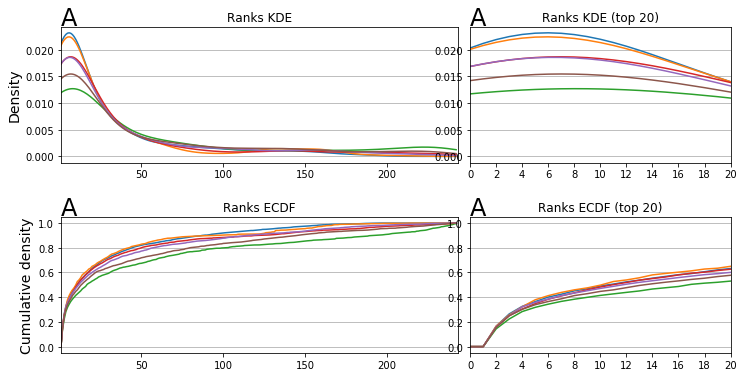

In [30]:
##Plot second figure:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
grid = plt.GridSpec(2, 5, wspace=0.1, hspace=0.4)
ax1 = fig.add_subplot(grid[0, :3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, :3])
ax4 = fig.add_subplot(grid[1, 3:]);
ax = [ax1, ax2, ax3, ax4]

def plot_fig_label(ax, lab):
    ax.text(-0.0, 1.15, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

for name in filenames:
    ranks = np.load(name+'.npy')
    kde = calc_kde(ranks)
    ecdf = calc_ecdf(ranks)
    ax1.plot(kde, label=name)
    ax2.plot(kde, label=name)
    ax3.plot(ecdf, label=name)
    ax4.plot(ecdf, label=name)

ax1.set_xlim(1,243)
ax1.set_title('Ranks KDE')
ax1.set_ylabel('Density', fontsize=14)
ax1.yaxis.grid()
plot_fig_label(ax1, 'A')

ax2.set_xlim(1,20)
ax2.set_title('Ranks KDE (top 20)')
ax2.yaxis.grid()
ax2.set_xticks(np.arange(0,21,2))
plot_fig_label(ax2, 'A')

ax3.set_xlim(1,243)
ax3.set_title('Ranks ECDF')
ax3.set_ylabel('Cumulative density', fontsize=14)
ax3.yaxis.grid()
plot_fig_label(ax3, 'A')

ax4.set_xlim(1,20)
ax4.set_title('Ranks ECDF (top 20)')
ax4.yaxis.grid()
ax4.set_xticks(np.arange(0,21,2))
plot_fig_label(ax4, 'A')


In [159]:
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import gaussian_kde
import numpy as np
plt.style.use('seaborn')


def calc_hpd(ranks, statistic=np.mean):
    with pm.Model() as model:
        #prior on statistic of interest:
        a = pm.Normal('a', mu=statistic(ranks), sigma=10.0)
        #'nuisance' parameter:
        b = pm.HalfNormal('b', sigma=10.0)
        #likelihood:
        if statistic==np.mean:
            y = pm.Normal('y', mu=a, sigma=b, observed=ranks)
        elif statistic==np.median:
            y = pm.Laplace('y', mu=a, b=b,observed=ranks)

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9)
        
    return trace

def calc_kde(ranks, xs=np.linspace(0,243,243)):
    #kde:
    density = gaussian_kde(ranks)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

# def calc_ecdf(ranks):
#     ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]
#     return ecdf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [160]:
r_lc = np.load('label_correlation.npy')
median_lc = calc_hpd(r_lc, np.median)
r_ibpr = np.load('hpo_implicit_bpr.npy')
median_ibpr = calc_hpd(r_ibpr, np.median)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1093.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 814.35draws/s] 


ValueError: operands could not be broadcast together with shapes (100,) (200,) 

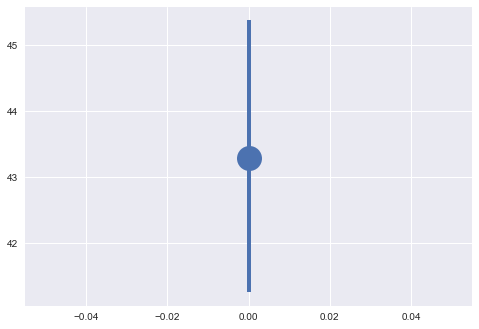

In [74]:
plt.errorbar(0, m, yerr = np.array([m-hpd[0], hpd[1]-m])[:,None],fmt='o', linewidth=4, markersize=25, capsize=3)
plt.fill_betweenx(xs,d,0, alpha=0.4)

In [ ]:
d

In [11]:
##First we will take the three best performing algorithms and
##take the geometric average of their rankings:
ranks = [np.load(name+'.npy') for name in ['label_correlation', 'hpo_implicit_bpr', 'hpo_lightfm_warp']]
geo_avg = np.power(ranks[0]*ranks[1]*ranks[2], 1/3)
np.save('geometric_avg', geo_avg)

##Now we can proceed to graph all the rankings:
##Filenames for the algos to load parameters:
filenames = ['geometric_avg', 'label_correlation', 'hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 858.62draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1392.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 855.63draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 886.17draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains 

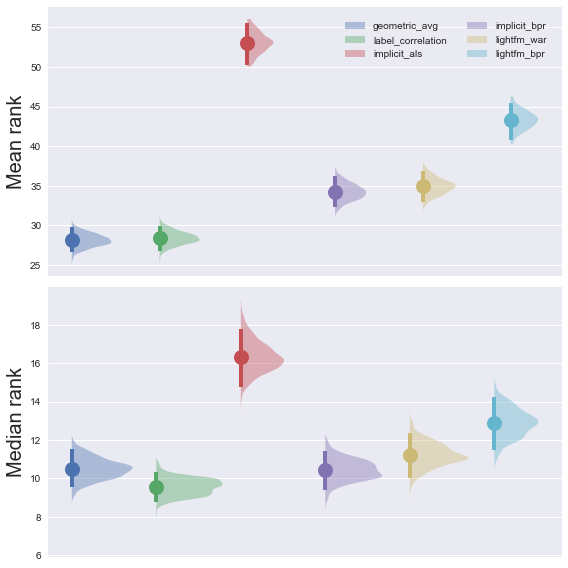

In [101]:
##Plot first figure:
fig, ax = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(8)

for count, name in enumerate(filenames):
    ranks = np.load(name+'.npy')
    mean_trace = calc_hpd(ranks, np.mean)
    median_trace = calc_hpd(ranks, np.median)
    
    for j,trace in zip([0,1], [mean_trace, median_trace]):
        m = np.mean(trace['a'])
        hpd = pm.hpd(trace['a'])
        xs = np.linspace(m-3,m+3,100)
        density = calc_kde(trace['a'], xs=xs)
        
        ax[j].errorbar(count, m, yerr = np.array([m-hpd[0], hpd[1]-m])[:,None],
                       fmt='o', linewidth=4, markersize=15, capsize=3)
        ax[j].fill_betweenx(xs,density+count,count, alpha=0.4,label=name.strip('hpo_'))


ax[0].set_ylabel('Mean rank', fontsize=20)
ax[0].set_xticks([])
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, ncol=2)

ax[1].set_ylabel('Median rank', fontsize=20)
ax[1].set_xticks([])

plt.tight_layout()

In [10]:
def calc_kde(ranks, xs=np.linspace(0,243,243)):
    #kde:
    density = gaussian_kde(ranks)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

In [7]:
def plot_fig_label(ax, lab):
    ax.text(0, 1.15, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

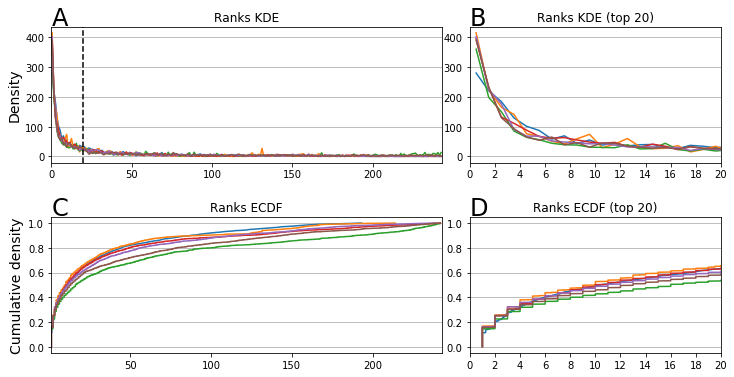

In [139]:
##Plot second figure:
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2, 5, wspace=0.25, hspace=0.4)
ax1 = fig.add_subplot(grid[0, :3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, :3])
ax4 = fig.add_subplot(grid[1, 3:]);
ax = [ax1, ax2, ax3, ax4]


for name in filenames:
    ranks = np.load(name+'.npy')
    inverse_ranks = 1/ranks
    #kde = calc_kde(inverse_ranks, xs= np.linspace(0,1.5,100))
    ecdf = ECDF(ranks)
    
    #ax1.plot(np.linspace(0,1.5,100), kde, label=name)
    #ax1.hist(ranks, bins=243, alpha=0.5)
    
    #n,x,_ = plt.hist(ranks, bins = np.linspace(0,243,243), histtype=u'step' )
    n,x =np.histogram(ranks, bins = np.linspace(0,243,243))
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax1.plot(bin_centers,n)
    ax2.plot(bin_centers,n)
    #ax2.plot(kde, label=name)
    #ax2.hist(ranks, bins=243, alpha=0.5)
    
#     ax3.scatter(ecdf.x, ecdf.y, label=name)
#     ax4.scatter(ecdf.x, ecdf.y, label=name)
    ax3.plot(ecdf.x, ecdf.y, label=name)
    ax4.plot(ecdf.x, ecdf.y, label=name)

ax1.set_xlim(0,243)
ax1.set_title('Ranks KDE')
ax1.set_ylabel('Density', fontsize=14)
ax1.yaxis.grid()
ax1.axvline(20, linestyle='--', c='k')
plot_fig_label(ax1, 'A')

ax2.set_xlim(1,20)
ax2.set_title('Ranks KDE (top 20)')
ax2.yaxis.grid()
ax2.set_xticks(np.arange(0,21,2))
plot_fig_label(ax2, 'B')

ax3.set_xlim(1,243)
ax3.set_title('Ranks ECDF')
ax3.set_ylabel('Cumulative density', fontsize=14)
ax3.yaxis.grid()
plot_fig_label(ax3, 'C')

ax4.set_xlim(1,20)
ax4.set_title('Ranks ECDF (top 20)')
ax4.yaxis.grid()
ax4.set_xticks(np.arange(0,21,2))
plot_fig_label(ax4, 'D')


(array([980., 323., 122., 104., 119.,   0.,  93.,   0., 130.,   0.,   0.,
          0., 233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 390.]),
 array([0.00413223, 0.04396694, 0.08380165, 0.12363636, 0.16347107,
        0.20330579, 0.2431405 , 0.28297521, 0.32280992, 0.36264463,
        0.40247934, 0.44231405, 0.48214876, 0.52198347, 0.56181818,
        0.60165289, 0.6414876 , 0.68132231, 0.72115702, 0.76099174,
        0.80082645, 0.84066116, 0.88049587, 0.92033058, 0.96016529,
        1.        ]),
 <a list of 25 Patch objects>)

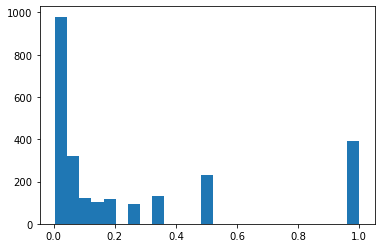

In [128]:
plt.hist(inverse_ranks, bins=25)

In [ ]:
for name in filenames:
    ranks = np.load(name+'.npy')
    plt.hist(ranks, bins=243, alpha=0.5)
    

geometric_avg 0.491579791499599
ModeResult(mode=array([1.]), count=array([280]))
label_correlation 0.5272654370489174
ModeResult(mode=array([1.]), count=array([415]))
hpo_implicit_als 0.42742582197273454
ModeResult(mode=array([1.]), count=array([360]))
hpo_implicit_bpr 0.5020048115477145
ModeResult(mode=array([1.]), count=array([395]))
hpo_lightfm_warp 0.4883720930232558
ModeResult(mode=array([1.]), count=array([402]))
hpo_lightfm_bpr 0.4599037690457097
ModeResult(mode=array([1.]), count=array([390]))


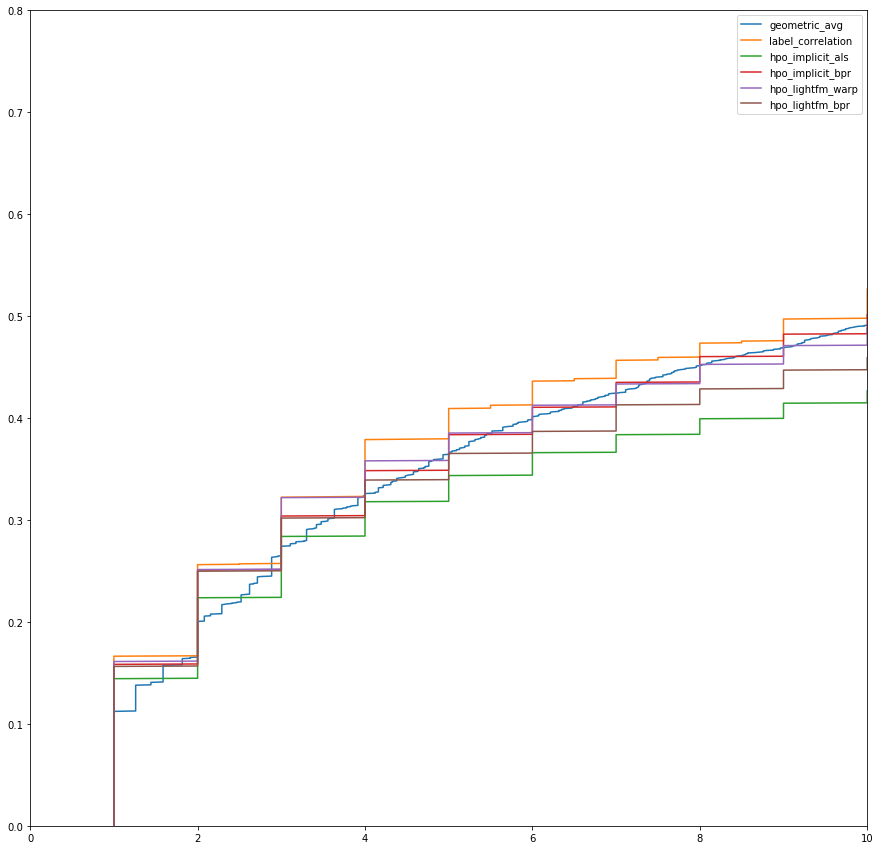

In [154]:
plt.figure(figsize=(15,15))
for name in filenames:
    ranks = np.load(name+'.npy')
    ecdf = ECDF(ranks)
    print(name, ecdf.y[np.where(ecdf.x>10)[0][0]])
    print(mode(ranks))
    #print(name, len(ranks[ranks<=1])/len(ranks))
    #kde = calc_kde(ranks)
    #ecdf = calc_ecdf(ranks)
    #print(np.arange(243)[(np.array(ecdf)>0.8)][0])
    plt.plot(ecdf.x, ecdf.y, label=name)
    
plt.xlim(0,10)
plt.ylim(0,0.8)
plt.legend()

In [152]:
from scipy.stats import mode

In [145]:
np.where(ecdf.x>5)[0][0]

912

In [144]:
ecdf.y[912]

0.3656776263031275

In [37]:
np.arange(243)[(np.array(ecdf)>0.8)]

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242])

In [17]:
with pm.Model() as model:
    #prior on statistic of interest:
    a = pm.Normal('a', mu=np.median(ranks), sigma=10.0)
    #'nuisance' parameter:
    b = pm.HalfNormal('b', sigma=10.0)

    y = pm.Laplace('y', mu=a, b=b,observed=ranks)

    trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1225.29draws/s]


In [76]:
density = gaussian_kde(trace['a'])
m = np.mean(trace['a'])
xs = np.linspace(m-3,m+3,100)
density.covariance_factor= lambda : 0.25
density._compute_covariance()
d = density(xs)

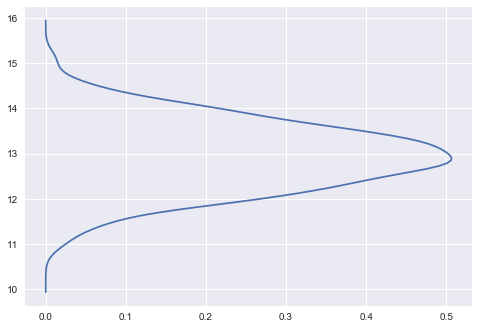

In [78]:
plt.plot(d,xs)

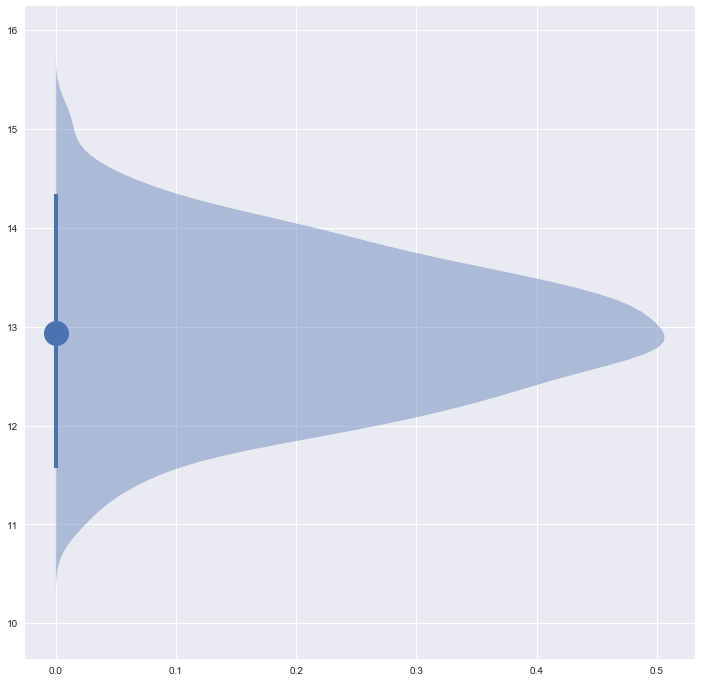

In [79]:
#plt.plot(d,xs)
plt.figure(figsize=(12,12))
hpd = pm.hpd(trace['a'])

plt.errorbar(0, m, yerr = np.array([m-hpd[0], hpd[1]-m])[:,None],fmt='o', linewidth=4, markersize=25, capsize=3)
plt.fill_betweenx(xs,d,0, alpha=0.4)

In [46]:
plt.errorbar(count, y, yerr=np.array([y-hpd[0], hpd[1]-y])[:,None],
                      label=fp,
                      fmt='o',
                      linewidth=4,
                     markersize=15, mfc='white', capsize=3)

array([11.5715218 , 14.34474948])

In [48]:
hpd

array([11.5715218 , 14.34474948])

In [53]:
np.array([m-hpd[0], hpd[1]-y])

array([1.3682401738086263, Elemwise{sub,no_inplace}.0], dtype=object)

In [56]:
hpd[1]-m

1.4049875053226621

In [2]:
filenames = ['label_correlation', 'hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr']



ranks  = [np.load(name+'.npy') for name in filenames]

In [3]:
def calc_kde(ranks):
    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

def calc_ecdf(ranks):
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]
    return ecdf

In [4]:
geometric_average_ranks = np.power(ranks[0]*ranks[2] * ranks[3], 1/3)

In [5]:
geometric_average_ranks

array([ 4.62606501, 68.57839959, 41.90758213, ...,  3.30192725,
        3.41995189,  3.30192725])

NameError: name 'ECDF' is not defined

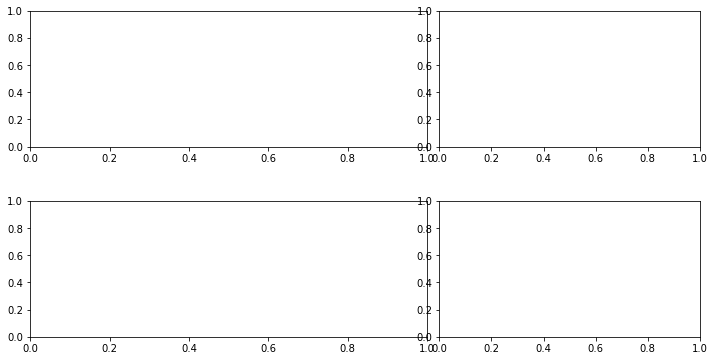

In [103]:
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2, 5, wspace=0.1, hspace=0.4)
ax1 = fig.add_subplot(grid[0, :3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, :3])
ax4 = fig.add_subplot(grid[1, 3:]);
ax = [ax1, ax2, ax3, ax4]
for name in filenames:
    ra = np.load(name+'.npy')
    kde = calc_kde(ra)
    #ecdf = calc_ecdf(ra)
    ecdf = ECDF(ra)
    ax1.plot(kde, label=name)
    ax2.plot(kde, label=name)
    ax3.plot(ecdf, label=name)
    ax4.plot(ecdf, label=name)
    
kde = calc_kde(geometric_average_ranks)
ecdf = calc_ecdf(geometric_average_ranks)
ax1.plot(kde, label='geo')
ax2.plot(kde, label='geo')
ax3.plot(ecdf, label='geo')
ax4.plot(ecdf, label='gep')

ax1.set_xlim(0,243)
ax1.set_title('Ranks KDE')
ax1.set_ylabel('Density', fontsize=14)
ax1.yaxis.grid()

ax2.set_xlim(0,20)
ax2.set_title('Ranks KDE (top 20)')
ax2.yaxis.grid()

ax3.set_xlim(0,243)
ax3.set_title('Ranks ECDF')
ax3.set_ylabel('Cumulative density', fontsize=14)
ax3.yaxis.grid()

ax4.set_xlim(0,20)
ax4.set_title('Ranks ECDF (top 20)')
ax4.yaxis.grid()

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

NameError: name 'prediction_ranks' is not defined

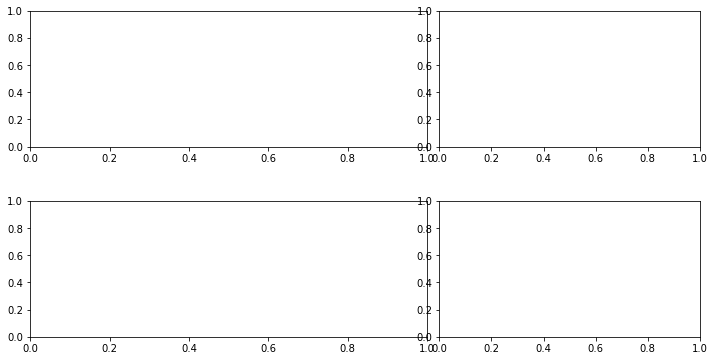

In [8]:
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2, 5, wspace=0.1, hspace=0.4)
ax1 = fig.add_subplot(grid[0, :3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, :3])
ax4 = fig.add_subplot(grid[1, 3:]);
ax = [ax1, ax2, ax3, ax4]
for ra in [prediction_ranks]:
    kde = calc_kde(ra)
    ecdf = calc_ecdf(ra)
    ax1.plot(kde, label=name)
    ax2.plot(kde, label=name)
    ax3.plot(ecdf, label=name)
    ax4.plot(ecdf, label=name)
    
#kde = calc_kde(geometric_average_ranks)
#ecdf = calc_ecdf(geometric_average_ranks)
ax1.plot(kde, label='geo')
ax2.plot(kde, label='geo')
ax3.plot(ecdf, label='geo')
ax4.plot(ecdf, label='gep')

ax1.set_xlim(0,243)
ax1.set_title('Ranks KDE')
ax1.set_ylabel('Density', fontsize=14)
ax1.yaxis.grid()

ax2.set_xlim(0,20)
ax2.set_title('Ranks KDE (top 20)')
ax2.yaxis.grid()

ax3.set_xlim(0,243)
ax3.set_title('Ranks ECDF')
ax3.set_ylabel('Cumulative density', fontsize=14)
ax3.yaxis.grid()

ax4.set_xlim(0,20)
ax4.set_title('Ranks ECDF (top 20)')
ax4.yaxis.grid()

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

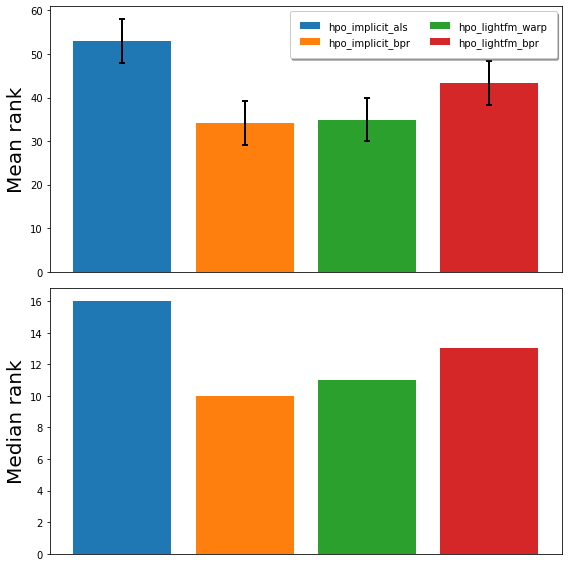

In [57]:
filenames = ['hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr']
##Plot first figure:
fig, ax = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(8)

for count, name in enumerate(filenames):
    ranks = np.load(name+'.npy')
    mean = np.mean(ranks)
    median = np.median(ranks)
    ax[0].bar(count, mean, label=name)
    ax[0].errorbar(count, mean, yerr=5, color='black', elinewidth=2, capsize=3, markeredgewidth=2);
    ax[1].bar(count, median, label=name)

ax[0].set_ylabel('Mean rank', fontsize=20)
ax[0].set_xticks([])
ax[1].set_ylabel('Median rank', fontsize=20)
ax[1].set_xticks([])

ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, ncol=2)


plt.tight_layout()
    #fig.savefig('statistics.png')
    #plt.close(fig)

In [54]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
##interaction_matrix = np.array(interaction_matrix.todense())
#
interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
##interaction_dates = np.array(interaction_dates.todense())

The publication dates of the interactions are recorded in ChEMBL. Looking below we can see the distribution of years: 

In [9]:
#removing 'year=1' which were originally NaNs in ChEMBL:
_ = kdeplot(interaction_dates.data[interaction_dates.data>1950], shade=True)
#bonus - set 'cumulative=True' in kdeplot to visualize the amount of data that will be in the test set.
plt.axvline(2010, c='red', label='test/train split point')
plt.legend()

NameError: name 'interaction_dates' is not defined

These can thus be used to perform time-split cross validation, which simulates prospective validation. The below sets a year, and creates a training matrix with all interactions equal to or before that year, and a test matrix with all interactions from after that year. 

In [2]:
train, test = utils.load_time_split()

In [6]:
#sparse.csr_matrix(train)

In [7]:
# interaction_matrix = utils.load_subset()

In [108]:
from scipy.stats.mstats import rankdata
def evaluate_predictions(predictions, test, train):

    if isinstance(test, sparse.csr_matrix):
        test = test.toarray()
    if isinstance(train, sparse.csr_matrix):
        train = train.toarray()
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()

    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool) #this will select using boolean all test ranks.
    
    
    predictions = np.ma.masked_array(predictions[row_mask], mask=train[row_mask].astype(bool))
    #rankdata approach, which correctly handles ties and also thankgod can take masked arrays:
    prediction_ranks = rankdata(-predictions, axis=1)
    
    #all ranks:
    all_test_ranks = prediction_ranks[get_ranks]
    return all_test_ranks

In [133]:
if isinstance(test, sparse.csr_matrix):
    test = test.toarray()
if isinstance(train, sparse.csr_matrix):
    train = train.toarray()
predictions=copy.copy(preds)
if isinstance(predictions, sparse.csr_matrix):
    predictions = predictions.toarray()

row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
test_masked = test[row_mask]
get_ranks = test_masked.astype(bool) #this will select using boolean all test ranks.
    
    
predictions = np.ma.masked_array(predictions[row_mask], mask=train[row_mask].astype(bool))

In [140]:
prediction_ranks = rankdata(-predictions, axis=1)

In [166]:
p = np.ma.masked_array(prediction_ranks, mask=~test[row_mask].astype(bool))

In [167]:
b=p.mean(axis=1)

In [180]:
np.mean(b)

34.93995585676259

In [162]:
p.shape

(1164, 243)

In [141]:
prediction_ranks[predictions.mask]

array([0., 0., 0., ..., 0., 0., 0.])

In [3]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_bpr'
params = utils.read_params(name)
preds = utils.train_implicit_bpr(params, train)
#ranks = utils.evaluate_predictions(preds, test, train)
#mean, median, kde, ecdf = score_ranks(ranks)
#print(mean, median)
for _ in range(7):
    preds+=utils.train_implicit_bpr(params, train)
    #ranks = utils.evaluate_predictions(preds, test, train)
    #mean, median, kde, ecdf = score_ranks(ranks)
    #print(mean, median)


CPU times: user 20 s, sys: 1.19 s, total: 21.2 s
Wall time: 19.9 s


In [6]:
#Trying long-format evaluation:
from scipy.stats.mstats import rankdata

In [4]:
predictions = copy.copy(preds)

if isinstance(test, sparse.csr_matrix):
    test = test.toarray()
if isinstance(train, sparse.csr_matrix):
    train = train.toarray()
if isinstance(predictions, sparse.csr_matrix):
    predictions = predictions.toarray()
    
#mask the known positives so they won't be calculated in the ranking:
predictions = np.ma.masked_array(predictions, mask=train.astype(bool))




In [7]:
%%time
prediction_ranks = rankdata(-predictions, axis=0)

CPU times: user 4min 16s, sys: 2.3 s, total: 4min 18s
Wall time: 4min 20s


In [8]:
print('hello')

hello


In [16]:
idx=0
prediction_ranks[:,idx][test.astype(bool)[:,idx]]

array([2.0488e+04, 1.7760e+03, 4.9180e+03, 2.9000e+01, 5.1958e+04,
       3.3076e+04, 3.7209e+04, 2.8000e+02, 1.0440e+03, 1.4850e+03,
       5.2862e+04, 4.1968e+04, 4.8850e+03, 1.5500e+02, 4.7270e+03,
       8.5050e+03, 1.3000e+01, 6.2830e+03, 8.5700e+02, 2.3240e+03,
       1.4093e+04, 1.4190e+03, 7.9500e+02, 2.3000e+01, 2.0000e+01,
       5.1600e+02, 4.8000e+01, 1.1000e+01, 2.1000e+01, 3.3000e+01])

In [9]:
test_ranks = prediction_ranks[test.astype(bool)]

In [13]:
test_ranks

array([ 1435.,  1770., 10426., ...,   613.,  7659.,   881.])

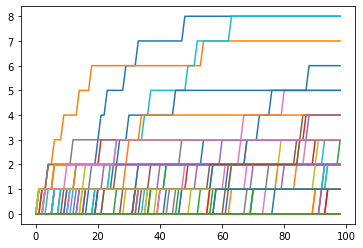

In [25]:
curve_list = list()
for idx in range(243):
    tranks = prediction_ranks[:,idx][test.astype(bool)[:,idx]]
    curve = [(tranks<i).sum() for i in range(1,100)]
    curve_list.append(curve)
    
    plt.plot(curve)
    
curve_list=np.array(curve_list)

In [48]:
percents = list()

results=list()
for j in range(99):
    results=list()
    for i in curve_list:
        results.append(i[j])
    percents.append( (np.array(results)>0).sum() / len(results))
    
#_ = plt.hist(results, bins=8, normed=True)

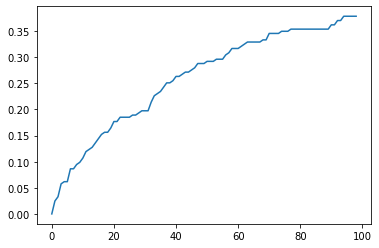

In [49]:
plt.plot(percents)

In [38]:
(np.array(results)>0).sum() / len(results)

0.26337448559670784

In [9]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_bpr'
params = utils.read_params(name)
preds_imp = utils.train_implicit_bpr(params, train)
#ranks = utils.evaluate_predictions(preds, test, train)
#mean, median, kde, ecdf = score_ranks(ranks)
#print(mean, median)
for _ in tqdm_notebook(range(1)):
    preds_imp+=utils.train_implicit_bpr(params, train)
    #ranks = utils.evaluate_predictions(preds, test, train)
    #mean, median, kde, ecdf = score_ranks(ranks)
    #print(mean, median)


CPU times: user 5.17 s, sys: 355 ms, total: 5.53 s
Wall time: 5.32 s


In [12]:
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)

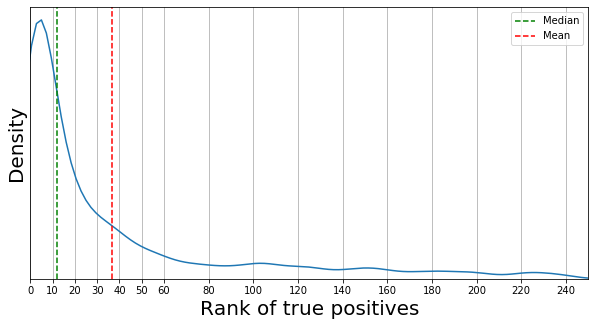

In [46]:
plt.figure(figsize=(10,5))
kdeplot(ranks_imp)
plt.xticks(np.concatenate([np.arange(0,51,10), np.arange(60,250,20)]))
plt.yticks([])
plt.xlim(0,250)
plt.grid()

plt.axvline(np.median(ranks_imp), label='Median', c='green',linestyle='--')
plt.axvline(np.mean(ranks_imp), label='Mean',c='red',linestyle='--')
plt.legend()
plt.ylabel('Density', fontsize=20)
plt.xlabel('Rank of true positives', fontsize=20)
plt.savefig('ranks_dist.png')

In [22]:
np.concatenate([np.arange(0,100,10), np.arange(100,250,20)])

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 120, 140,
       160, 180, 200, 220, 240])

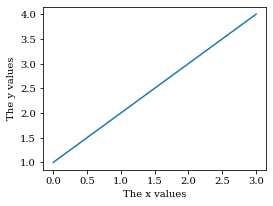

In [55]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot([1, 2, 3, 4])
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
fig.savefig('test.png')

In [ ]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot([1, 2, 3, 4])
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
fig.savefig('test.png')

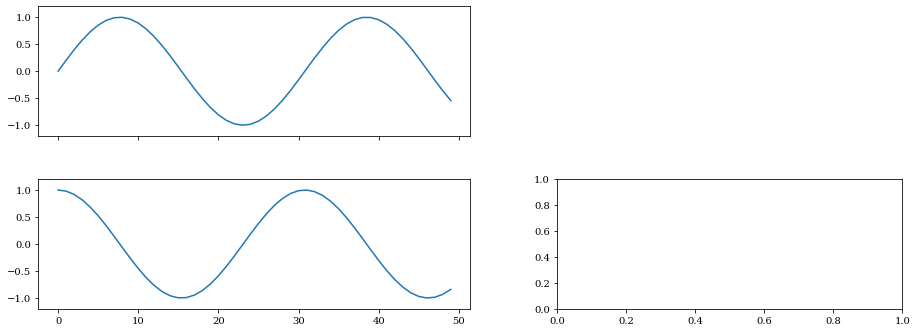

In [72]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.3],
                   xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.0, 0.1, 0.5, 0.3],
                   ylim=(-1.2, 1.2))

ax3 = fig.add_axes([0.6, 0.1, 0.4, 0.3])

x = np.linspace(0, 10)
ax1.plot(np.sin(x))
ax2.plot(np.cos(x));


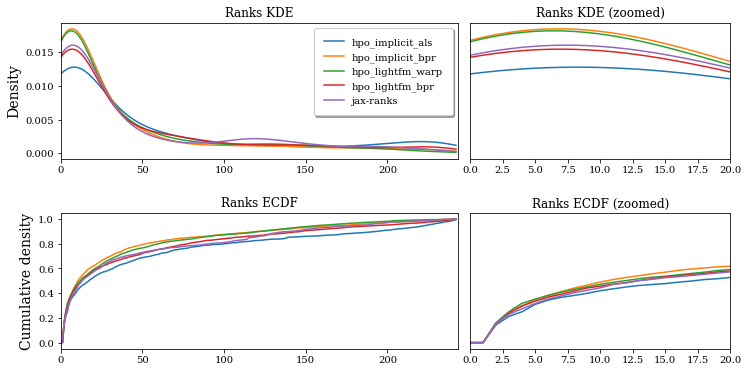

In [111]:
def calc_kde(ranks):
    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

def calc_ecdf(ranks):
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]
    return ecdf

filenames = ['hpo_implicit_als', 'hpo_implicit_bpr',
             'hpo_lightfm_warp', 'hpo_lightfm_bpr', 'jax-ranks']

fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2, 5, wspace=0.1, hspace=0.4)
ax1 = plt.subplot(grid[0, :3])
ax2 = plt.subplot(grid[0, 3:])
ax3 = plt.subplot(grid[1, :3])
ax4 = plt.subplot(grid[1, 3:]);
ax = [ax1, ax2, ax3, ax4]

for name in filenames:
    ranks = np.load(name+'.npy')
    kde = calc_kde(ranks)
    ecdf = calc_ecdf(ranks)
    ax1.plot(kde, label=name)
    ax2.plot(kde, label=name)
    ax3.plot(ecdf, label=name)
    ax4.plot(ecdf, label=name)

ax1.set_xlim(0,243)
ax1.set_title('Ranks KDE')
ax1.set_ylabel('Density', fontsize=14)

ax2.set_xlim(0,20)
ax2.set_title('Ranks KDE (top 20)')
ax2.set_yticks([])

ax3.set_xlim(0,243)
ax3.set_title('Ranks ECDF')
ax3.set_ylabel('Cumulative density', fontsize=14)

ax4.set_xlim(0,20)
ax4.set_title('Ranks ECDF (top 20)')
ax4.set_yticks([])
ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

In [8]:
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)

In [ ]:
#median corresponds to the minimum of the l1 norm! 
#https://statmodeling.stat.columbia.edu/2006/11/16/bayesian-inference-median/
l1norm=list()
for i in np.linspace(1,25,500):
    diffs = np.abs(i-ranks_imp)
    l1norm.append(np.sum(diffs))

In [ ]:
np.argmin(l1norm)

In [ ]:
np.linspace(1,25,500)[187]

In [ ]:
np.median(ranks_imp)

In [1]:
ranks

NameError: name 'ranks' is not defined

In [ ]:
plt.plot(np.linspace(1,25,500),l1norm)

In [5]:
ranks = np.load('jax-ranks.npy')

In [6]:
ranks

array([  4., 128.,  66., ...,   5.,   1.,   5.])

In [42]:
#Laplace distribution is related to l1 norm. 
#so we could use laplace as the likelihood for pymc3:

import pymc3 as pm

with pm.Model() as model:
    #prior:
    m = pm.Normal('m', mu=np.median(ranks), sigma=6.0)
    bee = pm.HalfNormal('bee', sigma=6.0)
    #likelihood:
    y = pm.Laplace('y', mu=m, b=bee,observed=ranks)
    #y = pm.Normal('y', mu=m, sigma=bee, observed=ranks)

In [43]:
with model:
    trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bee, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 733.99draws/s] 


In [49]:
from scipy import stats

n = stats.norm(0, 6)

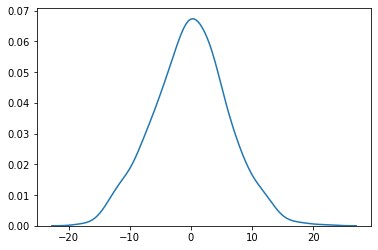

In [50]:
kdeplot(n.rvs(1000))

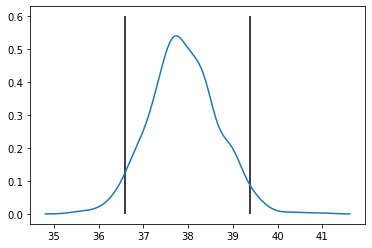

In [52]:
kdeplot(trace['bee'])
plt.vlines(pm.stats.hpd(trace['bee']),0,0.6)
#plt.axvline(np.median(ranks))

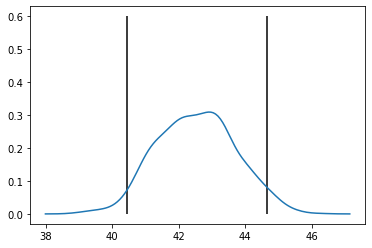

In [39]:
kdeplot(trace['m'])
plt.vlines(pm.stats.hpd(trace['m']),0,0.6)

In [24]:
def calc_hpd(ranks, statistic=np.mean):
    with pm.Model() as model:
        a = pm.Normal('a', mu=statistic(ranks), sigma=10.0)
        #'nuisance' parameter:
        b = pm.HalfNormal('b', sigma=10.0)
        #likelihood:
        if statistic==np.mean:
            y = pm.Normal('y', mu=a, sigma=b, observed=ranks)
        elif statistic==np.median:
            y = pm.Laplace('y', mu=a, b=b,observed=ranks)

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9)

    return statistic(ranks), pm.stats.hpd(trace['a'])

In [36]:
bah, pah = calc_hpd(ranks, np.median)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 976.89draws/s] 


In [37]:
pah.reshape(-1,1)

array([[11.10685041],
       [13.92148214]])

<BarContainer object of 1 artists>

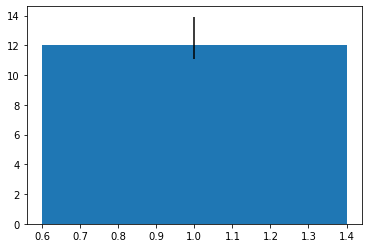

In [38]:
plt.bar(1, bah, yerr=[[bah-pah[0]], [pah[1]-bah]])

In [17]:
pm.stats.hpd(trace['m'])

array([40.72789503, 44.87369666])

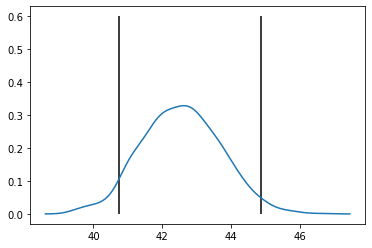

In [18]:
kdeplot(trace['m'])
plt.vlines(pm.stats.hpd(trace['m']),0,0.6)

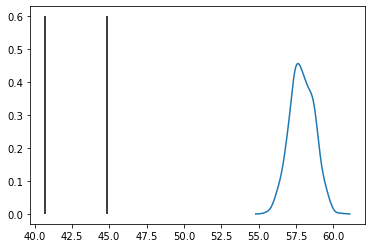

In [19]:
kdeplot(trace['bee'])
plt.vlines(pm.stats.hpd(trace['m']),0,0.6)

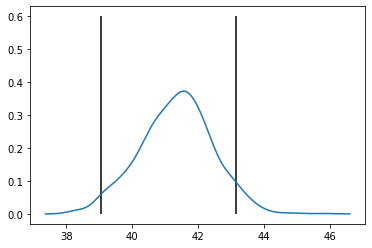

In [12]:
kdeplot(trace['m'])
plt.vlines(pm.stats.hpd(trace['m']),0,0.6)

In [ ]:
pm.plots.plot_posterior(trace, var_names=['m'])
plt.savefig('hi')

In [ ]:
kdeplot(trace['bee'])
plt.vlines(pm.stats.hpd(trace['bee']),0,0.6)

In [ ]:
from scipy import stats
plt.plot(np.linspace(-20,40,100), [stats.laplace(10.5,31).pdf(i) for i in np.linspace(-20,40,100)])


In [ ]:
pm.stats.hpd(trace['m'])

In [ ]:
pm.traceplot(trace, var_names=['m'])

In [ ]:
trace['m']

In [ ]:
import scikits.bootstrap as boot
#import numpy as np
boot.ci(ranks, np.median, n_samples=100)


In [ ]:
len(ranks)

In [ ]:
medians = list()
for _ in range(1000):
    beep = np.random.choice(ranks, 500)
    medians.append(np.median(beep))

In [ ]:
sorted(medians)[25]

In [ ]:
sorted(medians)[975]

In [ ]:
plt.hist(medians,bins=250)
#kdeplot(medians)
plt.axvline(8, c='k')
plt.axvline(13, c='k')

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_lightfm_warp'
params = utils.read_params(name)
preds_lfm = utils.train_lightfm_warp(params, train)
#ranks = utils.evaluate_predictions(preds, test, train)
#mean, median, kde, ecdf = score_ranks(ranks)
#print(mean, median)
for _ in tqdm_notebook(range(8)):
    preds_lfm+=utils.train_lightfm_warp(params, train)
    #ranks = utils.evaluate_predictions(preds, test, train)
    #mean, median, kde, ecdf = score_ranks(ranks)
    #print(mean, median)


In [ ]:
ranks_lfm = utils.evaluate_predictions(preds_lfm, test, train)

In [ ]:
np.vstack([ranks_lfm, ranks_imp]).T

In [ ]:
ranks_lfm

In [ ]:
import pandas as pd
bah = pd.DataFrame(data=np.vstack([ranks_lfm, ranks_imp]).T, columns=['lfm','bpr'])
bah.to_csv('lfm_vs_bpr.csv',index=False)

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_lightfm_bpr'
params = utils.read_params(name)
preds_lfm_bpr = utils.train_lightfm_bpr(params, train)
for _ in tqdm_notebook(range(8)):
    preds_lfm_bpr+=utils.train_lightfm_warp(params, train)

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_als'
params = utils.read_params(name)
preds_imp_als = utils.train_implicit_als(params, train)
for _ in tqdm_notebook(range(8)):
    preds_imp_als+=utils.train_implicit_als(params, train)

In [ ]:
ranks_lfm = utils.evaluate_predictions(preds_lfm, test, train)
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)
mean_lfm,median_lfm,kde_lfm,ecdf_lfm = score_ranks(ranks_lfm)
mean_imp,median_imp,kde_imp,ecdf_imp = score_ranks(ranks_imp)

In [ ]:
ranks_lfm_bpr = utils.evaluate_predictions(preds_lfm_bpr, test, train)
ranks_imp_als = utils.evaluate_predictions(preds_imp_als, test, train)

mean_lfm_bpr,median_lfm_bpr,kde_lfm_bpr,ecdf_lfm_bpr = score_ranks(ranks_lfm_bpr)
mean_imp_als,median_imp_als,kde_imp_als,ecdf_imp_als = score_ranks(ranks_imp_als)

In [ ]:
ranks_geo = (ranks_lfm*ranks_imp*ranks_lfm_bpr)**(1/3)
ranks_geo = (ranks_lfm*ranks_imp)**(1/2)
ranks_geo = (ranks_lfm*ranks_lfm_bpr)**(1/2)
mean_geo,median_geo,kde_geo,ecdf_geo = score_ranks(ranks_geo)

In [ ]:
print(mean_geo, median_geo)

In [ ]:
median_imp_als

In [ ]:
print(mean_geo, median_geo)

In [ ]:
plt.plot(kde_lfm, label='lfm_warp')
plt.plot(kde_lfm_bpr, label='lfm_bpr')
plt.plot(kde_imp, label='imp_bpr')
plt.plot(kde_imp_als, label='imp_als')
plt.plot(kde_geo, label='geo')

plt.legend()
plt.xlim(0,20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(ecdf_lfm, label='lfm_warp')
plt.plot(ecdf_lfm_bpr, label='lfm_bpr')
plt.plot(ecdf_imp, label='imp_bpr')
plt.plot(ecdf_imp_als, label='imp_als')
plt.plot(ecdf_geo, label='geo')

plt.legend()
plt.xlim(0,20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(ecdf_lfm, label='lfm')
plt.plot(ecdf_imp, label='imp')
plt.plot(ecdf_geo, label='geo')
plt.legend()
plt.xlim(0,20)

In [ ]:
ranks_lfm

In [ ]:
ranks_imp

In [ ]:
print(mean, median)
plt.plot(kde)

In [ ]:
def score_ranks(ranks):
    
    #normal statistics:
    mean = np.mean(ranks)
    median = np.median(ranks)

    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()

    #empirical cumulative distribution function:
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]

    return mean, median, density(xs), ecdf

In [ ]:
year = 2010

#turn interaction dates into a masker
dates_mask = (interaction_dates.data<=year).astype(int)

#make copies that will become train / test matrices
train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

#remove 2015 and later records from train matrix
train.data = train.data * dates_mask
#remove all training data from the test matrix. 
test.data = test.data - train.data

#remove any rows from the train matrix that have zero interactions.
#this is the case any time a new ligand is discovered in 2015 or after. 
#we can't use link prediction on new ligands! It's a cold start problem. 
#so we remove all these ligands from the present analysis. 
row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask] 
test = test[row_mask]

train.eliminate_zeros()
test.eliminate_zeros()

In [ ]:
name = 'hpo_implicit_bpr'
parameter_flag=False
params = dict()
for line in open('../hyperparameter_optimization/'+name+'.dat', 'r').readlines():
    if 'Result' in line:
        parameter_flag=False
    if parameter_flag:
        words = line.split()
        params[words[0]]=float(words[1])
        print(line.split())
    if 'Best parameters' in line:
        parameter_flag=True

In [ ]:
params

In [ ]:
utils.train_implicit_bpr(train)

In [ ]:
def score_ranks(ranks):
    
    #normal statistics:
    mean = np.mean(ranks)
    median = np.median(ranks)

    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()

    #empirical cumulative distribution function:
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]

    return mean, median, density(xs), ecdf

In [ ]:
mean, med, kde, ecdf = plot_ranks(ranks)

In [ ]:
from matplotlib.gridspec import GridSpec
fig, ax = plt.subplots(2,2)
gs = GridSpec(2, 2, width_ratios=[[6,2],[6,2]])
for i in range(4):
    ax[i][j].set_position(gs[i].get_position(fig))


In [ ]:
gs[4]

In [ ]:
#plt.plot(ecdf)
plt.plot(kde)

In [ ]:
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]


In [ ]:
pars = find_opt_pars('hpo_implicit_bpr.dat')
pars

In [ ]:
def train_implicit_bpr(pars, inp):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)
    model.fit(sparse.csr_matrix(inp), show_progress=False)
    return np.dot(model.item_factors, model.user_factors.T)


pars = find_opt_pars('hpo_implicit_bpr.dat')
implicit_bpr_preds = train_implicit_bpr(pars, train)
for _ in range(7):
    implicit_bpr_preds += train_implicit_bpr(pars, train)
implicit_bpr_ranks = utils.evaluate_predictions(implicit_bpr_preds, test)

In [ ]:
def train_implicit_als(pars, inp):
    model = implicit.als.AlternatingLeastSquares(factors=params['factors'],
                                                 regularization=params['regularization'],
                                                 iterations=params['iterations'],
                                                 num_threads=1,
                                                 use_gpu=False)
    model.fit(train)
    return np.dot(model.item_factors, model.user_factors.T)
        #evaluate by calculating mean rank:
        results.append(utils.evaluate_predictions(pred_matrix, test).mean())

    return np.mean(results)

In [ ]:
import implicit
means = list()
medians = list()
kdes = list()

model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
model.fit(train)

imbpr_preds = np.dot(model.item_factors, model.user_factors.T)
ranks = utils.evaluate_predictions(imbpr_preds, test)
m, med, kde = plot_ranks(ranks)
means.append(m)
medians.append(med)
kdes.append(kde)

for _ in range(5):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
    model.fit(train)

    imbpr_preds += np.dot(model.item_factors, model.user_factors.T)
    ranks = utils.evaluate_predictions(imbpr_preds, test)
    m, med, kde = plot_ranks(ranks)
    means.append(m)
    medians.append(med)
    kdes.append(kde)

In [ ]:
for _ in range(10):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
    model.fit(train)

    imbpr_preds += np.dot(model.item_factors, model.user_factors.T)
    ranks = utils.evaluate_predictions(imbpr_preds, test)
    m, med, kde = plot_ranks(ranks)
    means.append(m)
    medians.append(med)
    kdes.append(kde)

In [ ]:
for k in kdes:
    plt.plot(k)

In [ ]:
plt.plot(means)

In [ ]:
plt.plot(np.arange(len(medians)),medians)

In [ ]:
import lightfm
means2 =list()
medians2=list()
kdes2=list()

##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))

ranks = utils.evaluate_predictions(lfm_prediction_matrix, test)
m, med, kde = plot_ranks(ranks)
means2.append(m)
medians2.append(med)
kdes2.append(kde)

for _ in range(10):
    print(_)
    model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
    model.fit(sparse.csr_matrix(train), epochs=6)

    temp = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    lfm_prediction_matrix+=np.reshape(temp, (len(cid), len(tid)))
    
    ranks = utils.evaluate_predictions(lfm_prediction_matrix, test)
    m, med, kde = plot_ranks(ranks)
    means2.append(m)
    medians2.append(med)
    kdes2.append(kde)





In [ ]:
plt.plot(means2)

In [ ]:
plt.plot(medians2)

In [ ]:
for i in kdes2:
    plt.plot(i)

In [ ]:
ranks1 = utils.evaluate_predictions(imbpr_preds, test)
ranks2 = utils.evaluate_predictions(lfm_prediction_matrix, test)

In [ ]:
plt.scatter(ranks1, ranks2, alpha=0.2)

In [ ]:
from scipy.stats.mstats import rankdata
one = rankdata(-imbpr_preds[:,0])
two = rankdata(-lfm_prediction_matrix[:,0])

In [ ]:
one

In [ ]:
plt.scatter(one, two, alpha=0.005)

In [ ]:
indices = np.argsort(one)

plt.scatter(three[indices][:10000], one[indices][:10000], alpha=0.1)

In [ ]:
import statsmodels.api as sm
model = sm.OLS(one[indices][:10000], two[indices][:10000])
results = model.fit()f
print(results.summary())

In [ ]:
kdeplot(one,two)

# Predict label scores using label correlation

In [ ]:
##This version uses sparse matrices, which keeps everything low
##memory. But it's a bit slower because getting/setting sparse objects is in general
##slower than numpy. 
def makeCorrelations(y_in):
    assert isinstance(y_in, sparse.csr_matrix)
    tot_instances = np.array(y_in.sum(axis=0))[0]
    L = sparse.lil_matrix((y_in.shape[1], y_in.shape[1]))

    for idx in tqdm_notebook(range(y_in.shape[0]), smoothing=0.1):
        row = y_in[idx]
        if row.sum()>1:
            for j,k in itertools.permutations(row.nonzero()[1], 2):
                L[j,k] += (1)/(tot_instances[k])             
    return L

##This calculates predicted probabilities for labels (1's in the train matrix are preserved as 1's)
def makePredictions(y_in, L):
    L1 = 1-L.toarray() #working with dense array is much easier for this. 
                    #but because it's only numLabels x numLabels it's not that big.
    y_new = y_in.toarray().astype('float32') #working with a dense array again
                                             #for ease of row-wise, elementwise addition 
    for count, row in tqdm_notebook(enumerate(y_in), total=y_in.shape[0], smoothing=0.1):
        posLines = row.nonzero()[1]
        corrs = L1[:,posLines]
        probs = 1-np.prod(corrs, axis=1)
        y_new[count]+=probs #elementwise addition here. 
        y_new[count] = np.clip(y_new[count], 0, 1)
    return sparse.csr_matrix(y_new)

In [ ]:
L = makeCorrelations(train)
lc_preds = makePredictions(train, L)

In [ ]:
three = rankdata(-lc_preds.toarray()[:,0])

In [ ]:
plt.scatter(one, three, alpha=0.005)

In [ ]:
plt.scatter(two, three, alpha=0.005)

In [ ]:
bap = [1,2]
stdevs =list()
stdevs.append(np.std(bap))
for _ in range(100):
    bap.append(2)
    stdevs.append(np.std(bap))

In [ ]:
plt.plot(stdevs)

In [ ]:
def bapbap(predictions, test):
    #if isinstance(test, sparse.csr_matrix):
    #    test = test.toarray()

    #This will mask all ROWS that contain no test ligands. No point ranking
    #a row if you're aren't going to evaluate the ranks!
    #(and it works on sparse or np.array)
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

In [ ]:
def get_ranks_masked():
    predictions = copy.copy(lc_preds)
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()
        
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
    prediction_ranks = rankdata(-predictions2, axis=1)
    return prediction_ranks[get_ranks.toarray()]


In [ ]:
def get_ranks_unmasked():
    predictions = copy.copy(lc_preds)
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()
        
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    #predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)
    return prediction_ranks[get_ranks.toarray()]

In [ ]:
r_masked = get_ranks_masked()
r_unmasked = get_ranks_unmasked()

In [ ]:
kdeplot(r_masked)
kdeplot(r_unmasked)

In [ ]:
r_masked

In [ ]:
r_unmasked

In [ ]:
predictions = copy.copy(lc_preds)



if isinstance(predictions, sparse.csr_matrix):
	predictions = predictions.toarray()

#predictions = np.ma.masked_array(predictions, mask=train.toarray()[row_mask].astype(bool))    
    
from scipy.stats.mstats import rankdata
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)

test_masked = test[row_mask]
get_ranks = test_masked.astype(bool)

predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
prediction_ranks = rankdata(-predictions2, axis=1)

In [ ]:
kdeplot(prediction_ranks[get_ranks.toarray()])

In [ ]:
get_ranks.toarray()

# Predict label scores using implicit BPR:

In [ ]:
import implicit
model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
model.fit(train)

imbpr_preds = np.dot(model.item_factors, model.user_factors.T)

In [ ]:
def return_mean_rank(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

In [ ]:
lc_ranks = return_mean_rank(lc_preds.toarray(), test)

In [ ]:
imbpr_ranks = return_mean_rank(imbpr_preds, test)

In [ ]:
plt.figure(figsize=(15,8))
kdeplot(lc_ranks, label='Label correlation', cumulative=True)
kdeplot(imbpr_ranks, label='ImplicitBPR', cumulative=True)
plt.yscale('log')

In [104]:
from statsmodels.distributions import ECDF
ecdf = ECDF(lc_ranks)

NameError: name 'lc_ranks' is not defined

In [ ]:
lc_ranks

In [ ]:
plt.figure(figsize=(15,6))
ecdf = ECDF(lc_ranks)
plt.plot(ecdf.x, ecdf.y, label='Label correlation')
ecdf = ECDF(imbpr_ranks)
plt.plot(ecdf.x, ecdf.y, label='ImplicitBPR')

In [ ]:
plt.figure(figsize=(15,8))
#bal = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot([(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 256)])
plt.plot([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])
plt.grid()

In [ ]:
sum([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

In [ ]:
sum([(lc_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

In [ ]:
print(np.median(pa))
print(np.median(wa))

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
order

In [ ]:
order2.T

In [ ]:
kdeplot(ranks2[test.T])

In [ ]:
from lightfm import LightFM, datasets
data = datasets.fetch_movielens()


In [ ]:
data['train']

In [ ]:
ranks2[test.T]

In [ ]:
kdeplot(ranks[test])

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [ ]:
test.toarray().astype(bool)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
import lightfm
##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))


In [ ]:
order_lc = (-lc_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lc = order_lc.argsort()

order_im = (-im_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_im = order_im.argsort()

order_lfm = (-lfm_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lfm = order_lfm.argsort()

In [ ]:
inverse_ranks_lc = 1/(order_lc.argsort()+1)
inverse_ranks_im = 1/(order_im.argsort()+1)
inverse_ranks_lfm = 1/(order_lfm.argsort()+1)

In [ ]:
inverse_combined = inverse_ranks_lc+inverse_ranks_im+inverse_ranks_lfm

In [ ]:
order_com = (-inverse_combined).argsort()
#get ranks of each ligand. 
ranks_com = order_com.argsort()
print(np.mean(ranks_com[np.array(test, dtype=bool)]))

In [ ]:
avg_ranks = (ranks_lc+ranks_im)/2

In [ ]:
print(np.mean(ranks_lc[np.array(test, dtype=bool)]))

print(np.mean(ranks_im[np.array(test, dtype=bool)]))

print(np.mean(avg_ranks[np.array(test, dtype=bool)]))

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
print(np.mean(test_ranks))
print(np.median(test_ranks))

plt.figure(figsize=(10,3))
density = gaussian_kde(test_ranks)
xs = np.linspace(0,243, 300)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.axhline(0, c='k')
#plt.xlim(-0.5,150)
plt.scatter(test_ranks, np.zeros(len(test_ranks))+np.random.uniform(-0.02,0.0, len(test_ranks)), alpha=0.05)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [ ]:
ranks

In [ ]:
###load data:
#train, test = utils.load_time_split()

filenames = ['hpo_implicit_als.dat', 'hpo_implicit_bpr.dat',
             'hpo_lightfm_warp.dat', 'hpo_lightfm_bpr.dat']
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]




def train_implicit_als(pars):
    model = implicit.als.AlternatingLeastSquares(factors=int(pars[0]),
                                                     regularization=pars[1],
                                                     iterations=int(pars[2]),
                                                     num_threads=1,
                                                     use_gpu=False)
    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)



##LightFM:
#lightfm 'user id' (chemical id)
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)
tid = np.arange(train.shape[1])



def train_lightfm_warp(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='warp',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_lightfm_bpr(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='bpr',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)




In [ ]:
def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(train)
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return prediction_matrix

def score_prediction_matrix(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

#bpr:
pars = find_opt_pars(filenames[1])
preds = train_implicit_bpr(pars)
r = score_prediction_matrix(preds, test)

mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
#ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]

for _ in range(16):
    preds += train_implicit_bpr(pars)
    r = score_prediction_matrix(preds, test)
    mean = np.mean(r)
    print(mean)
    median = np.median(r)
    print(median)


#    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')


In [ ]:
preds
t = test.toarray().astype(bool)

In [ ]:
#order from highest to lowest:
order = (-lc_preds.toarray()).argsort(axis=1)
#get ranks of each ligand.
ranks = order.argsort(axis=1)

In [ ]:
for j,k in zip(*test.toarray().nonzero()):
    value = lc_preds[j,k]
    if value==0:
        one = (-lc_preds.toarray()[j]).argsort()
        two = one.argsort()
        print('Found a zero, is is rank:',two[k])
    print(j,k, value)

In [ ]:
a = np.array([[4,2,7,2,1],[1,2,3,4,5]])
rank = a.argsort(axis=1).argsort(axis=1)

unique, inverse = np.unique(a, return_inverse = True, axis=0)

unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_count = np.zeros_like(unique)
np.add.at(unique_count, inverse, 1)

unique_rank_mean = unique_rank_sum.astype(np.float) / unique_count

rank_mean = unique_rank_mean[inverse]

rank_mean

In [ ]:
unique, inverse = np.unique(a, return_inverse = True, axis=1)
unique

In [ ]:
unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_rank_sum

In [ ]:
print(-lc_preds.toarray()[0][227])
one = (-lc_preds.toarray()[0]).argsort()
two = one.argsort()



In [ ]:
two[(-lc_preds.toarray()[0]==0)]

In [ ]:
plt.scatter((-lc_preds.toarray()[0]).argsort(), (-lc_preds.toarray()[0]))

In [ ]:
from scipy.stats import rankdata

plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]))

In [ ]:
from scipy.stats.mstats import rankdata
rankdata(-lc_preds.toarray()[:13000], axis=1)

In [ ]:
rm = np.array(test.sum(axis=1)>0).reshape(-1,)

In [ ]:
test

In [ ]:
%%timeit
rm_ranked = rankdata(-lc_preds.toarray()[rm], axis=1)

In [ ]:
trm = test.toarray()[rm].astype(bool)

In [ ]:
test.toarray()[rm]

In [ ]:
trm

In [ ]:
rm_ranked

In [ ]:
def bapbap(predictions, test):
    
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.toarray().astype(bool) #this will select using boolean all test ranks.

    #rankdata approach, which correctly handles ties:
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

    #all ranks:
    prediction_ranks[get_ranks]
    return prediction_ranks

In [ ]:
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
row_mask

In [ ]:
test_masked = test[row_mask]
test_masked

In [ ]:
get_ranks = test_masked.toarray().astype(bool)
get_ranks

In [ ]:
-lc_preds[row_mask].toarray()

In [ ]:
prediction_ranks = rankdata(-lc_preds[row_mask].toarray(), axis=1)

In [ ]:
lc_preds

In [ ]:
all_test_ranks = prediction_ranks[get_ranks]

In [ ]:
kdeplot(all_test_ranks)

In [ ]:
test.shape

In [ ]:
np.median(rm_ranked[trm])

In [ ]:
trm

In [ ]:
rankdata(-lc_preds.toarray()[0])[lc_preds.toarray()[0]==0]

In [ ]:
from scipy.stats.mstats import rankdata
plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]), alpha=0.1)

In [ ]:
for j,k in zip(ranks, t):
    if sum(k)!=0:
        v = np.mean(j[k])
        print(v)

In [ ]:
k

In [ ]:
preds[0][t[0]]

In [ ]:
r = score_prediction_matrix(preds, test)
pr = score_prediction_matrix(lc_preds.toarray(), test)

In [ ]:
pr = rm_ranked[trm]

In [ ]:
pr

In [ ]:
plt.figure(figsize=(15,8))
mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]
plt.plot(ecdf, label='ImplicitBPR')



pr = score_prediction_matrix(lc_preds.toarray(), test)
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr')


pr = rm_ranked[trm]
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr.Avg')

plt.legend()
##plt.ylim(0,20)
plt.xlim(0,20)

In [ ]:
mean = np.mean(lc_ranks)
print(mean)
median = np.median(lc_ranks)
print(median)
ecdf = [(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 243)]


In [ ]:
plt.plot(ecdf)

In [ ]:
#kdeplot(lc_ranks)
kdeplot(r)


In [ ]:
#outfile = open('results.dat', 'w')
#outfile.write('algorithm, mean, median\n')

##implicit:
#als:
pars = find_opt_pars(filenames[0])
for _ in range(3):
    mean, median = train_implicit_als(pars)
    #outfile.write(filenames[0]+': '+str(mean)+' '+str(median)+'\n')

#bpr:
pars = find_opt_pars(filenames[1])
for _ in range(3):
    mean, median = train_implicit_bpr(pars)
    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')

##lightfm
#warp
pars = find_opt_pars(filenames[2])
for _ in range(3):
    mean, median = train_lightfm_warp(pars)
    outfile.write(filenames[2]+': '+str(mean)+' '+str(median)+'\n')

#bpr
pars = find_opt_pars(filenames[3])
for _ in range(3):
    mean, median = train_lightfm_bpr(pars)
    outfile.write(filenames[3]+': '+str(mean)+' '+str(median)+'\n')

#label correlation:
L1 = 1- utils.makeCorrelations(train)
prediction_matrix = utils.makeProbabilities(train, L1)
test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test), avg=False)
outfile.write('label correl: '+str(np.mean(test_ranks))+' '+str(np.median(test_ranks))+'\n')


outfile.close()